## Import 

In [396]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import binom, poisson, norm
warnings.filterwarnings('ignore') # Suppress warnings

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [397]:
# custom_palette = sns.color_palette('bright', n_colors=10)
# sns.set(style="whitegrid")
# sns.set_context("notebook")
# sns.set_palette(custom_palette)


## Dataset 1_route_quarter - Exploration and Cleaning
#### Explore route_quarter dataset
#### Dataset describes travel to and from Ireland by routes between the years of 1985 and 2008, Quarterly, by Route of Travel.

In [398]:
# Read csv file into pandas dataframe 
# url = https://data.gov.ie/dataset/tmq01-visits-to-and-from-ireland/resource/d018a88d-6944-4728-aa62-cd05074ffa5e
# route_quarter_TMQ01-Visits-to-and-from-Ireland dataset contains 8 columns and 960 rows 
# (24 years in Quarters = 96 rows), 96 rows by 2 Direction = 192 rows, 192 rows by 5 regions = 960 rows
# Columns: ROUTE, Route of Travel, TLIST(Q1), Quarter,STATISTIC, Statistic Label, UNIT, VALUE
route_quarter_tourism = pd.read_csv("TMQ01-Visits-to-and-from-Ireland.csv")
route_quarter_tourism.shape
print(route_quarter_tourism.columns)
route_quarter_tourism.head()

(960, 8)

Index(['ROUTE', 'Route of Travel', 'TLIST(Q1)', 'Quarter', 'STATISTIC',
       'Statistic Label', 'UNIT', 'VALUE'],
      dtype='object')


,ROUTE,Route of Travel,TLIST(Q1),Quarter,STATISTIC,Statistic Label,UNIT,VALUE
0,0,All Routes,19851,1985Q1,TMQ01C1,Visitors to Ireland,Thousand,254
1,0,All Routes,19851,1985Q1,TMQ01C2,Visits Abroad by Irish Residents,Thousand,186
2,0,All Routes,19852,1985Q2,TMQ01C1,Visitors to Ireland,Thousand,495
3,0,All Routes,19852,1985Q2,TMQ01C2,Visits Abroad by Irish Residents,Thousand,336
4,0,All Routes,19853,1985Q3,TMQ01C1,Visitors to Ireland,Thousand,840


## Display value counts for each column in the dataframe

In [399]:
route_quarter_tourism['ROUTE'].value_counts()
route_quarter_tourism['Route of Travel'].value_counts()
route_quarter_tourism['TLIST(Q1)'].value_counts()
route_quarter_tourism['Quarter'].value_counts()
route_quarter_tourism['STATISTIC'].value_counts()
route_quarter_tourism['Statistic Label'].value_counts()
route_quarter_tourism['UNIT'].value_counts()
route_quarter_tourism['VALUE'].value_counts(bins=5)

ROUTE
0    192
1    192
2    192
3    192
4    192
Name: count, dtype: int64

Route of Travel
All Routes            192
Air Cross Channel     192
Sea Cross Channel     192
Continental Europe    192
Transatlantic         192
Name: count, dtype: int64

TLIST(Q1)
19851    10
19852    10
20023    10
20022    10
20021    10
20014    10
20013    10
20012    10
20011    10
20004    10
20003    10
20002    10
20001    10
19994    10
19993    10
19992    10
19991    10
19984    10
19983    10
19982    10
19981    10
19974    10
19973    10
20024    10
20031    10
20032    10
20062    10
20083    10
20082    10
20081    10
20074    10
20073    10
20072    10
20071    10
20064    10
20063    10
20061    10
20033    10
20054    10
20053    10
20052    10
20051    10
20044    10
20043    10
20042    10
20041    10
20034    10
19972    10
19971    10
19964    10
19881    10
19902    10
19901    10
19894    10
19893    10
19892    10
19891    10
19884    10
19883    10
19882    10
19874    10
19904    10
19873    10
19872    10
19871    10
19864    10
19863    10
19862    10
19861    10
19854    10
19853    10
19903    10
19911    10
19963    10
19941    10
19962    10
19961    10
19954    10
19953    10
19952    10
19951    10
19944    10
19943 

Quarter
1985Q1    10
1985Q2    10
2002Q3    10
2002Q2    10
2002Q1    10
2001Q4    10
2001Q3    10
2001Q2    10
2001Q1    10
2000Q4    10
2000Q3    10
2000Q2    10
2000Q1    10
1999Q4    10
1999Q3    10
1999Q2    10
1999Q1    10
1998Q4    10
1998Q3    10
1998Q2    10
1998Q1    10
1997Q4    10
1997Q3    10
2002Q4    10
2003Q1    10
2003Q2    10
2006Q2    10
2008Q3    10
2008Q2    10
2008Q1    10
2007Q4    10
2007Q3    10
2007Q2    10
2007Q1    10
2006Q4    10
2006Q3    10
2006Q1    10
2003Q3    10
2005Q4    10
2005Q3    10
2005Q2    10
2005Q1    10
2004Q4    10
2004Q3    10
2004Q2    10
2004Q1    10
2003Q4    10
1997Q2    10
1997Q1    10
1996Q4    10
1988Q1    10
1990Q2    10
1990Q1    10
1989Q4    10
1989Q3    10
1989Q2    10
1989Q1    10
1988Q4    10
1988Q3    10
1988Q2    10
1987Q4    10
1990Q4    10
1987Q3    10
1987Q2    10
1987Q1    10
1986Q4    10
1986Q3    10
1986Q2    10
1986Q1    10
1985Q4    10
1985Q3    10
1990Q3    10
1991Q1    10
1996Q3    10
1994Q1    10
1996Q2    10
1996

STATISTIC
TMQ01C1    480
TMQ01C2    480
Name: count, dtype: int64

Statistic Label
Visitors to Ireland                 480
Visits Abroad by Irish Residents    480
Name: count, dtype: int64

UNIT
Thousand    960
Name: count, dtype: int64

(2.359, 533.0]      711
(533.0, 1061.0]     158
(1061.0, 1589.0]     51
(1589.0, 2117.0]     26
(2117.0, 2645.0]     14
Name: count, dtype: int64

## Edit Dataframe 1 - Data Cleaning 
### Remove, Rename and Transform columns

In [400]:
# Remove 'UNIT' column as 'VALUE' column heading will be amended to reflect units. 
# Remove 'ROUTE' column as 'Route of Travel' contains the same information in human readable language.
# Remove 'STATISTIC' column as this data is contained within 'Quarter' and 'Statistic Label' columns in human readable language.
route_quarter_tourism = route_quarter_tourism.drop(columns=['UNIT', 'ROUTE', 'STATISTIC'])

# Rename 'TLIST(Q1)' column to Year
route_quarter_tourism.rename(columns={"TLIST(Q1)": "Year"}, inplace=True)

# Last character in 'Year' column refers to quarter (1-4) 
# Remove last character from by dividing by 10 and saving as integer to remove non-whole numbers. e.g. 19854 -> 1985.4 = 1985
route_quarter_tourism["Year"] = route_quarter_tourism["Year"].transform(lambda x: x / 10).astype(int)

# The'Quarter' column contains the year and Q before the number designating the quarter. e.g. 1985Q4
# Transform 'Quarter' column, reassigning last character of each entry as integer reflecting the quarter. e.g. 1985Q4 = 4
route_quarter_tourism["Quarter"] = route_quarter_tourism["Quarter"].transform(lambda x: str(x)[-1]).astype(int)

# Rename 'Statistic Label' column for Direction
route_quarter_tourism.rename(columns={"Statistic Label": "Direction"}, inplace=True)

# Rename Column for Travellers x 1,000
route_quarter_tourism.rename(columns={"VALUE": "Travellers x(1,000)"}, inplace=True)

route_quarter_tourism.shape

(960, 5)

### Explore edited route_quarter dataset

In [401]:
route_quarter_tourism.shape
print(route_quarter_tourism.columns)
route_quarter_tourism.head()

(960, 5)

Index(['Route of Travel', 'Year', 'Quarter', 'Direction',
       'Travellers x(1,000)'],
      dtype='object')


,Route of Travel,Year,Quarter,Direction,"Travellers x(1,000)"
0,All Routes,1985,1,Visitors to Ireland,254
1,All Routes,1985,1,Visits Abroad by Irish Residents,186
2,All Routes,1985,2,Visitors to Ireland,495
3,All Routes,1985,2,Visits Abroad by Irish Residents,336
4,All Routes,1985,3,Visitors to Ireland,840


## Display value counts for each column in the edited dataframe

In [402]:
route_quarter_tourism['Route of Travel'].value_counts()
route_quarter_tourism['Year'].value_counts()
route_quarter_tourism['Quarter'].value_counts()
route_quarter_tourism['Direction'].value_counts()
route_quarter_tourism['Travellers x(1,000)'].value_counts(bins=5)

Route of Travel
All Routes            192
Air Cross Channel     192
Sea Cross Channel     192
Continental Europe    192
Transatlantic         192
Name: count, dtype: int64

Year
1985    40
1986    40
2007    40
2006    40
2005    40
2004    40
2003    40
2002    40
2001    40
2000    40
1999    40
1998    40
1997    40
1996    40
1995    40
1994    40
1993    40
1992    40
1991    40
1990    40
1989    40
1988    40
1987    40
2008    40
Name: count, dtype: int64

Quarter
1    240
2    240
3    240
4    240
Name: count, dtype: int64

Direction
Visitors to Ireland                 480
Visits Abroad by Irish Residents    480
Name: count, dtype: int64

(2.359, 533.0]      711
(533.0, 1061.0]     158
(1061.0, 1589.0]     51
(1589.0, 2117.0]     26
(2117.0, 2645.0]     14
Name: count, dtype: int64

## Assessing Cross Channel travel into and out of Ireland over time.

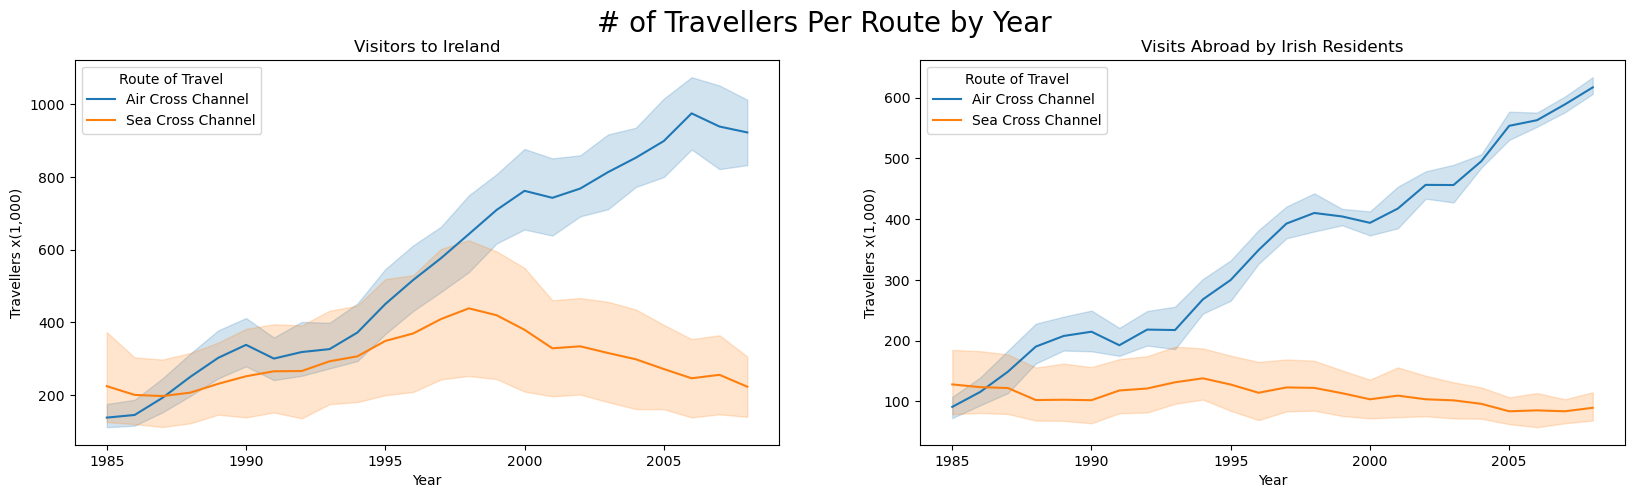

In [403]:
# Declare variable for easier access to direction of travel
VISITORS_TO_IRELAND = 'Visitors to Ireland'
VISITORS_FROM_IRELAND = 'Visits Abroad by Irish Residents'

FILTER_CROSS_CHANNEL = ((route_quarter_tourism['Route of Travel'] == 'Air Cross Channel') | (route_quarter_tourism['Route of Travel'] == 'Sea Cross Channel'))

to_ireland_df = route_quarter_tourism.loc[FILTER_CROSS_CHANNEL & (route_quarter_tourism['Direction'] ==  VISITORS_TO_IRELAND)]
from_ireland_df = route_quarter_tourism.loc[FILTER_CROSS_CHANNEL & (route_quarter_tourism['Direction'] ==  VISITORS_FROM_IRELAND)]

### Start of Data Visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

#plt.xticks(rotation=45)
sns.lineplot(x="Year", y="Travellers x(1,000)", hue="Route of Travel", data=to_ireland_df, ax=axes[0]);
axes[0].set_title(VISITORS_TO_IRELAND);

sns.lineplot(x="Year", y="Travellers x(1,000)", hue="Route of Travel", data=from_ireland_df, ax=axes[1]);
axes[1].set_title(VISITORS_FROM_IRELAND);
                  
fig.suptitle('# of Travellers Per Route by Year', fontsize=20);


### Defining a function to determine frequency distribution of each route of cross channel travel for incoming and outgoing travel

In [404]:
# Calculate the sum for all Routes of Travel per **year - quarter - direction**
def calculate_frequencies(df):
    print(df.shape)

    sums = df.groupby(['Year', 'Quarter', 'Direction'], as_index=False).sum()
    sums.rename(columns={"Travellers x(1,000)": "Total Num"}, inplace=True)

    # Calculate the number of unique routes, because this is how many times we need to repeat each sum for the division operation
    repeats = df['Route of Travel'].nunique()
    # Extract the total numbers per **year - quarter - direction** and repeat them 3 times, because we have 3 routes
    mask = sums.loc[sums.index.repeat(repeats)].reset_index(drop=True)['Total Num']
    print(mask.shape) # I am making sure the shape of the mask matches the shape of the dataframe we will apply this to

    mask.head()

    # We have to prodive 'ignore_index=True', because otherwise the division by the totals_mask will produce NaN values, as indexes are misaligned
    df.sort_values(by=['Year', 'Quarter', 'Direction', 'Route of Travel'], inplace=True, ignore_index=True)

    #concatenated_route_quarter_tourism['Distribution']
    df['Distribution Per Route'] = df['Travellers x(1,000)'] / mask
    return df

(384, 5)
(384,)


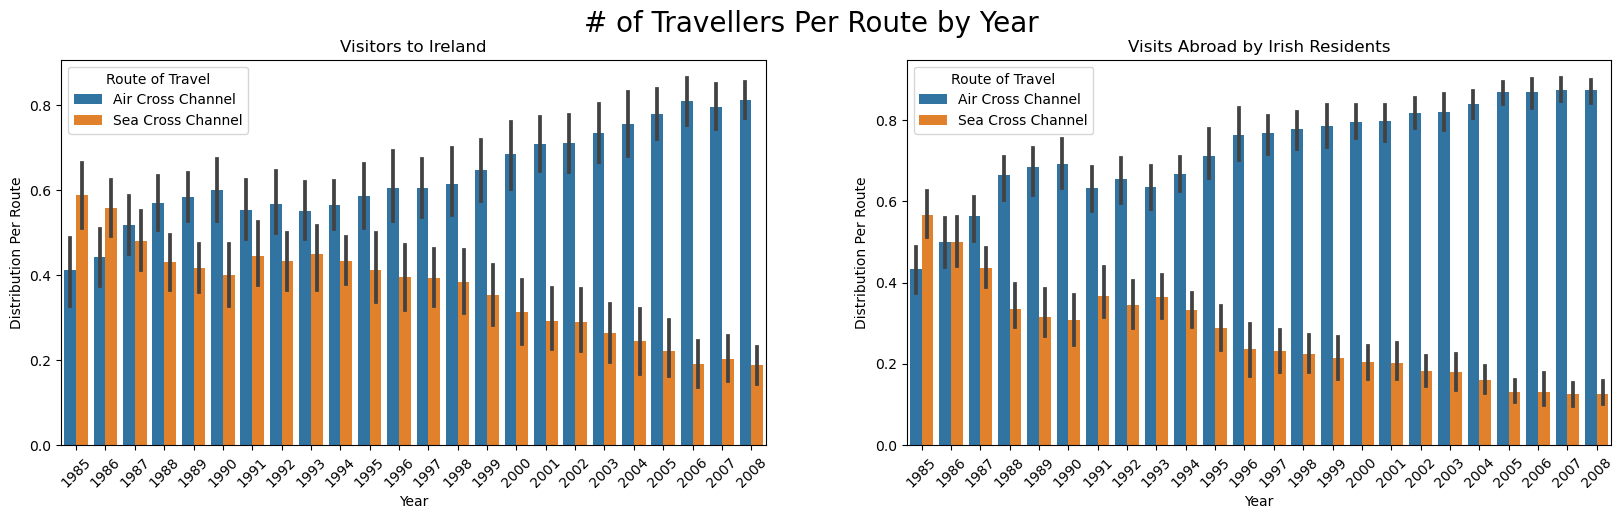

In [405]:
x_channel = route_quarter_tourism.loc[FILTER_CROSS_CHANNEL]
freqs = calculate_frequencies(x_channel)
freqs['year quarter'] = freqs['Year'].astype(str) + 'Q' + freqs['Quarter'].astype(str)
freqs

to_ireland_df = freqs.loc[(freqs['Direction'] ==  VISITORS_TO_IRELAND)]
from_ireland_df = freqs.loc[(freqs['Direction'] ==  VISITORS_FROM_IRELAND)]

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.barplot(x="Year", y="Distribution Per Route", hue="Route of Travel", data=to_ireland_df, ax=axes[0])
axes[0].set_title(VISITORS_TO_IRELAND);
axes[0].tick_params(axis='x', rotation=45);

sns.barplot(x="Year", y="Distribution Per Route", hue="Route of Travel", data=from_ireland_df, ax=axes[1])
axes[1].set_title(VISITORS_FROM_IRELAND);
axes[1].tick_params(axis='x', rotation=45);

fig.suptitle('# of Travellers Per Route by Year', fontsize=20);

In [406]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# ax = sns.lineplot(x="Year", y="Distribution Per Route", hue="Route of Travel", data=freqs)
# plt.xticks(rotation=45)
# ax.set_title('Distribution Per Route by Year')
# plt.show(); # Put semicolon as per https://stackoverflow.com/questions/51030011/maplotlib-gives-the-list-of-array-outputs-before-showing-the-scatter-plot-in-pyt as otherise it will show the array of the output before the

### Assessing change in distribution of route of travel cross channel per Quarter over time

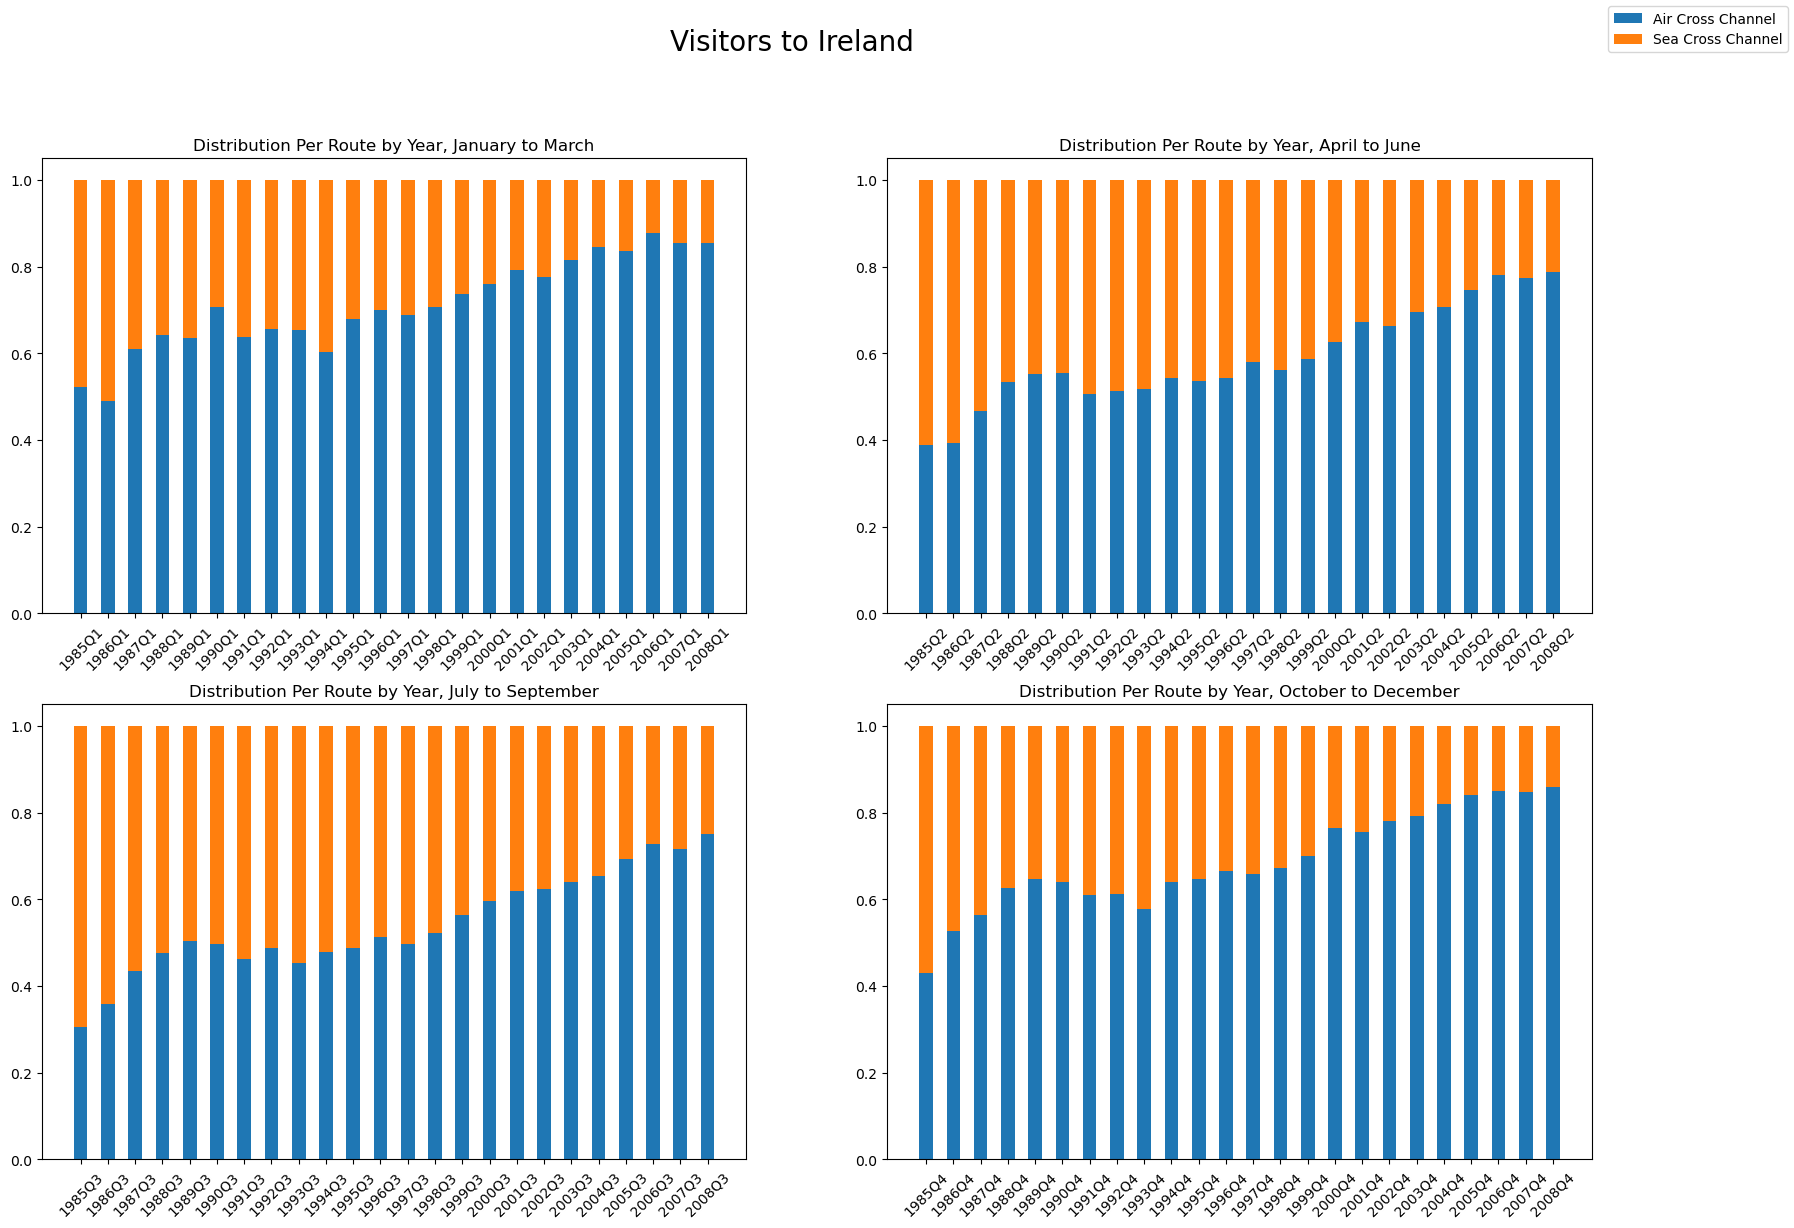

In [407]:
def plot_by_quarter(df, title):
    fig, axes = plt.subplots(2, 2, figsize=(20, 13))

    q1 = df.loc[(df['Quarter'] == 1)]
    air1 = q1.loc[q1['Route of Travel'] == 'Air Cross Channel']
    _ = axes[0, 0].bar(air1['year quarter'], air1['Distribution Per Route'], 0.5, label='Air Cross Channel', bottom=0)
    sea1 = q1.loc[q1['Route of Travel'] == 'Sea Cross Channel']
    _ = axes[0, 0].bar(sea1['year quarter'], sea1['Distribution Per Route'], 0.5, label='Sea Cross Channel', bottom=air1['Distribution Per Route'].to_numpy())

    q2 = df.loc[(df['Quarter'] == 2)]
    air2 = q2.loc[q2['Route of Travel'] == 'Air Cross Channel']
    _ = axes[0, 1].bar(air2['year quarter'], air2['Distribution Per Route'], 0.5, label='Air Cross Channel', bottom=0)
    sea2 = q2.loc[q2['Route of Travel'] == 'Sea Cross Channel']
    _ = axes[0, 1].bar(sea2['year quarter'], sea2['Distribution Per Route'], 0.5, label='Sea Cross Channel', bottom=air2['Distribution Per Route'].to_numpy())

    q3 = df.loc[(df['Quarter'] == 3)]
    air3 = q3.loc[q3['Route of Travel'] == 'Air Cross Channel']
    _ = axes[1, 0].bar(air3['year quarter'], air3['Distribution Per Route'], 0.5, label='Air Cross Channel', bottom=0)
    sea3 = q3.loc[q3['Route of Travel'] == 'Sea Cross Channel']
    _ = axes[1, 0].bar(sea3['year quarter'], sea3['Distribution Per Route'], 0.5, label='Sea Cross Channel', bottom=air3['Distribution Per Route'].to_numpy())

    q4 = df.loc[(df['Quarter'] == 4)]
    air4 = q4.loc[q4['Route of Travel'] == 'Air Cross Channel']
    _ = axes[1, 1].bar(air4['year quarter'], air4['Distribution Per Route'], 0.5, label='Air Cross Channel', bottom=0)
    sea4 = q4.loc[q4['Route of Travel'] == 'Sea Cross Channel']
    _ = axes[1, 1].bar(sea4['year quarter'], sea4['Distribution Per Route'], 0.5, label='Sea Cross Channel', bottom=air4['Distribution Per Route'].to_numpy())

    axes[0, 0].xaxis.set_tick_params(rotation=45)
    axes[0, 0].set_title('Distribution Per Route by Year, January to March')

    axes[0, 1].xaxis.set_tick_params(rotation=45)
    axes[0, 1].set_title('Distribution Per Route by Year, April to June')

    axes[1, 0].xaxis.set_tick_params(rotation=45)
    axes[1, 0].set_title('Distribution Per Route by Year, July to September')

    axes[1, 1].xaxis.set_tick_params(rotation=45)
    axes[1, 1].set_title('Distribution Per Route by Year, October to December')

    # Taken from https://stackoverflow.com/questions/9834452/how-do-i-make-a-single-legend-for-many-subplots
    h, l = axes[0, 0].get_legend_handles_labels()
    fig.legend(h, l, loc='upper right')
    fig.suptitle(title, fontsize=20);
    plt.show();

plot_by_quarter(to_ireland_df, VISITORS_TO_IRELAND)


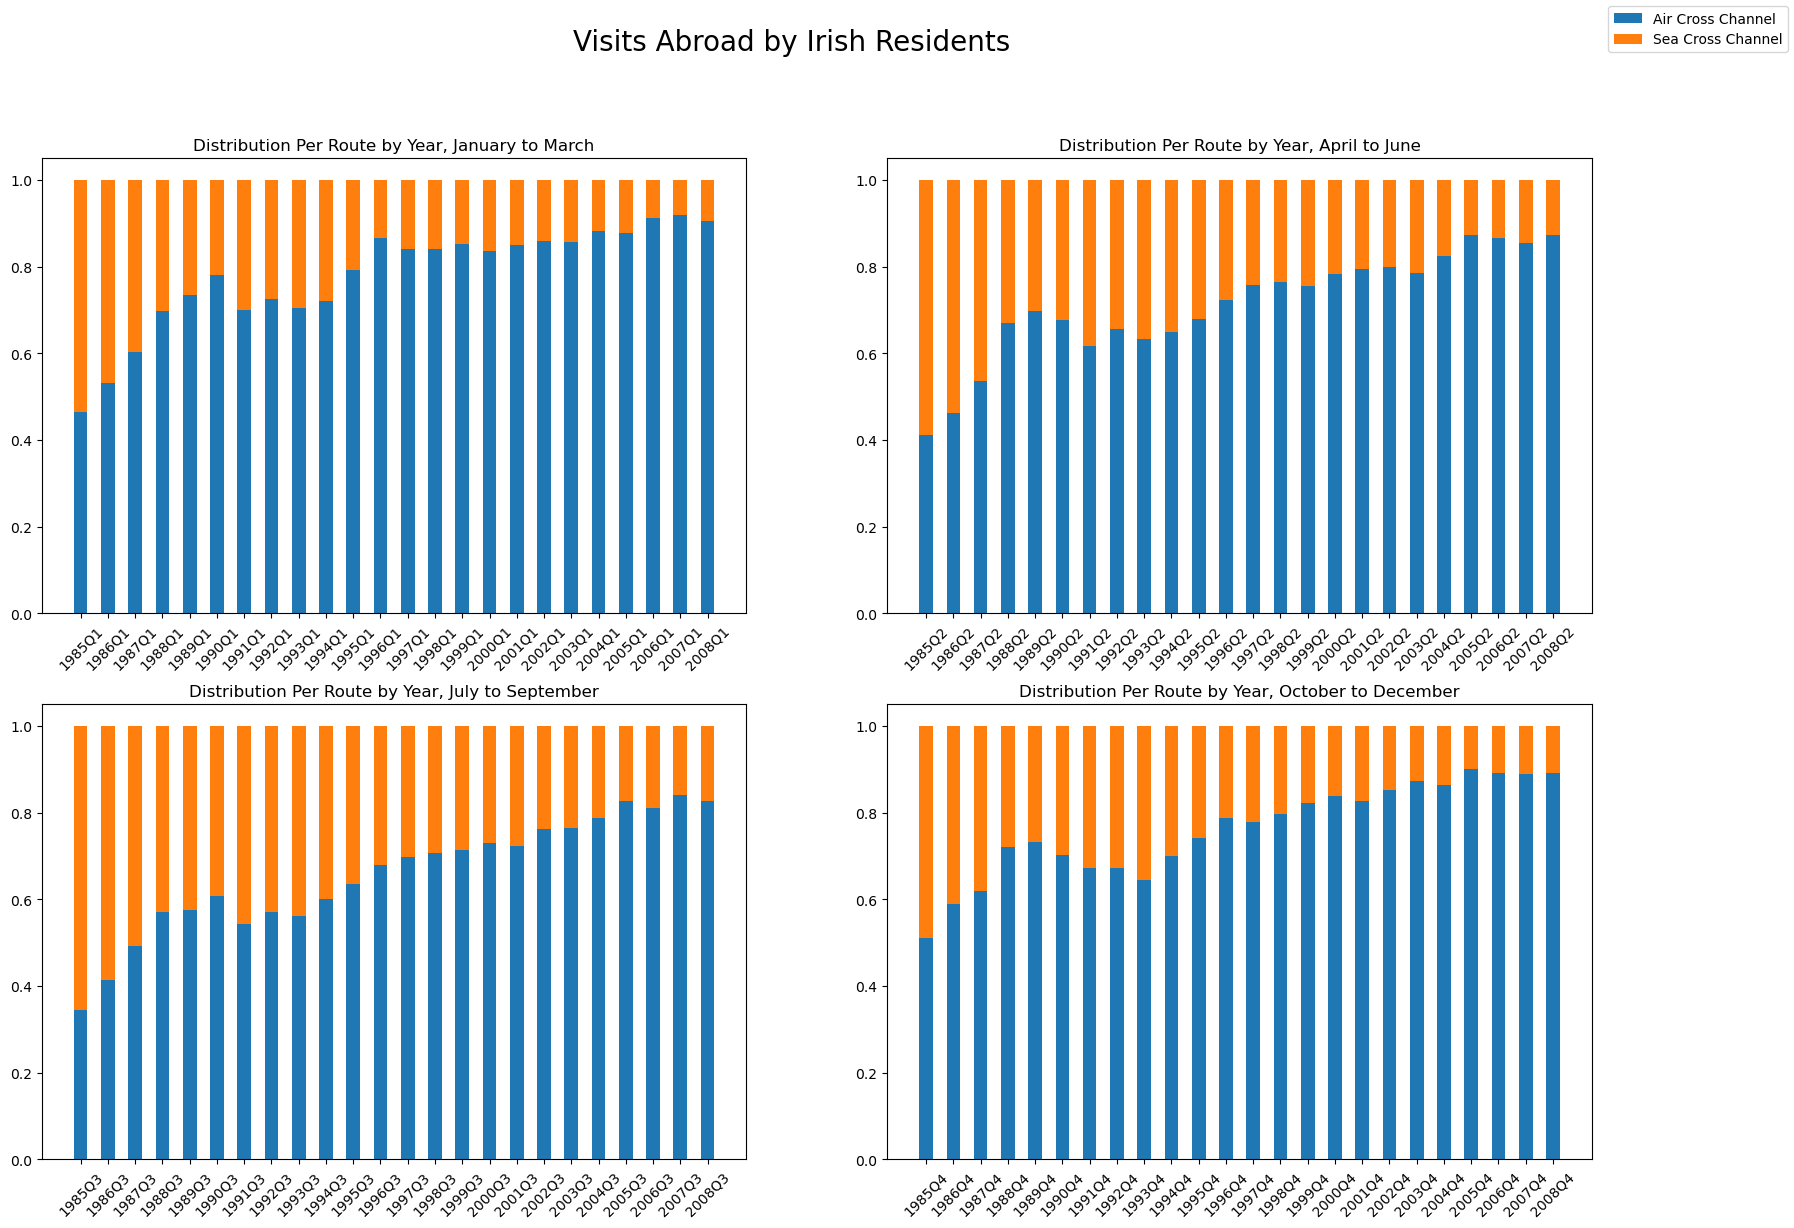

In [408]:
plot_by_quarter(from_ireland_df, VISITORS_FROM_IRELAND)


### Merge Air and Sea Cross channel values into combined Cross Channel values

In [409]:
def merge_air_and_sea(df, common_cols):
    # Select cross channel travel by both sea and air for each quarter and year from the dataset
    cross_channel_df = df[df.isin(['Air Cross Channel', 'Sea Cross Channel'])['Route of Travel']==True]
    #pd.set_option('display.max_rows', cross_channel_df.shape[0]+1)
    cross_channel_df.shape
    
    # Combine Air and Sea cross channel travel into Cross channel travel dataframe
    combined_cross_channel = cross_channel_df.groupby(common_cols, as_index=False).sum()
    combined_cross_channel['Route of Travel'] = 'Cross Channel'
    combined_cross_channel.shape

    # Remove Air and Sea Cross Channel travel from original dataset
    df = df.drop(df[df.isin(['Air Cross Channel', 'Sea Cross Channel'])['Route of Travel']==True].index)
    # Concatenate original dataset with new Cross Channel travel dataset
    df = pd.concat([df, combined_cross_channel], axis=0, ignore_index=True)
    #pd.set_option('display.max_rows', df.shape[0]+1)
    # df
    # Change order of routes to "All Routes", "Cross Channel", "Continental Europe", and "Transatlantic" to be consistent with the original dataset.
    concatenated_df = pd.concat([df[df['Route of Travel'] == 'All Routes'],
                                df[df['Route of Travel'] == 'Cross Channel'],
                                df[df['Route of Travel'] == 'Continental Europe'],
                                df[df['Route of Travel'] == 'Transatlantic']])

    # Reset the index of the concatenated dataframe
    concatenated_df.reset_index(drop=True, inplace=True)
    return concatenated_df

In [410]:
concatenated_route_quarter_tourism = merge_air_and_sea(route_quarter_tourism, ['Year', 'Quarter', 'Direction'])
concatenated_route_quarter_tourism['Route of Travel'].value_counts()

Route of Travel
All Routes            192
Cross Channel         192
Continental Europe    192
Transatlantic         192
Name: count, dtype: int64

### Removing All routes values for Route of Travel

In [411]:
concatenated_route_quarter_tourism = concatenated_route_quarter_tourism.drop(concatenated_route_quarter_tourism[concatenated_route_quarter_tourism.isin(['All Routes'])['Route of Travel']==True].index)
# Calculate the distribution of travellers per route
concatenated_route_quarter_tourism = calculate_frequencies(concatenated_route_quarter_tourism)
concatenated_route_quarter_tourism


(576, 5)
(576,)


,Route of Travel,Year,Quarter,Direction,"Travellers x(1,000)",Distribution Per Route
0,Continental Europe,1985,1,Visitors to Ireland,28,0.110236
1,Cross Channel,1985,1,Visitors to Ireland,211,0.830709
2,Transatlantic,1985,1,Visitors to Ireland,15,0.059055
3,Continental Europe,1985,1,Visits Abroad by Irish Residents,41,0.220430
4,Cross Channel,1985,1,Visits Abroad by Irish Residents,140,0.752688
...,...,...,...,...,...,...
571,Cross Channel,2008,4,Visitors to Ireland,981,0.589189
572,Transatlantic,2008,4,Visitors to Ireland,101,0.060661
573,Continental Europe,2008,4,Visits Abroad by Irish Residents,806,0.492966
574,Cross Channel,2008,4,Visits Abroad by Irish Residents,677,0.414067


## Assessing distribution of travellers to Ireland by different routes of travel over time

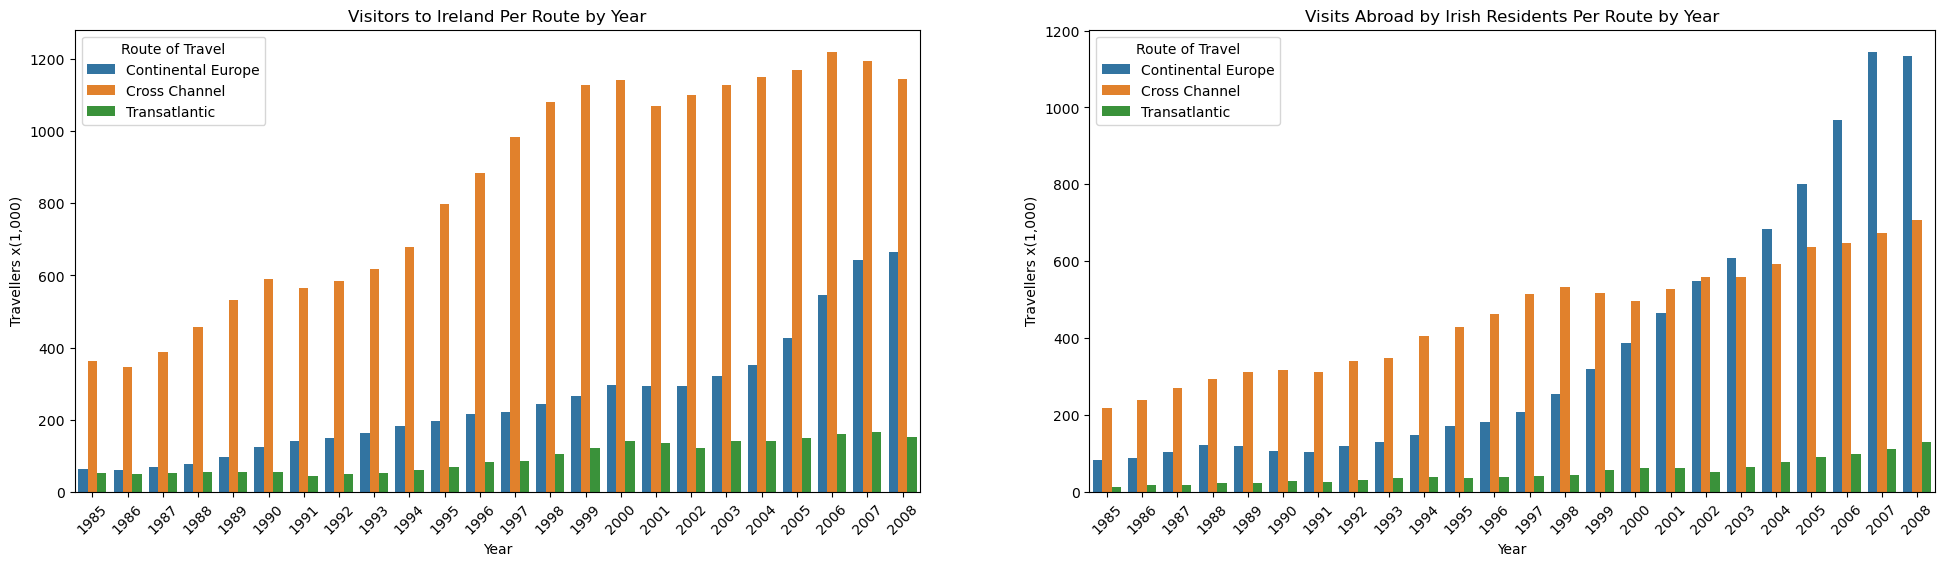

In [412]:
to_ireland_df = concatenated_route_quarter_tourism[concatenated_route_quarter_tourism['Direction'] == VISITORS_TO_IRELAND]
from_ireland_df = concatenated_route_quarter_tourism[concatenated_route_quarter_tourism['Direction'] == VISITORS_FROM_IRELAND]

fig, axes = plt.subplots(1, 2, figsize=(24, 6)) 

sns.barplot(x='Year', y='Travellers x(1,000)', data=to_ireland_df, hue='Route of Travel', ci=None, ax=axes[0]);
axes[0].set_title(VISITORS_TO_IRELAND + ' Per Route by Year');
axes[0].tick_params(axis='x', rotation=45);
sns.barplot(x='Year', y='Travellers x(1,000)', data=from_ireland_df, hue='Route of Travel', ci=None, ax=axes[1]);
axes[1].set_title(VISITORS_FROM_IRELAND + ' Per Route by Year');
axes[1].tick_params(axis='x', rotation=45);


### Assessing Distribution of travellers from Ireland per route over time

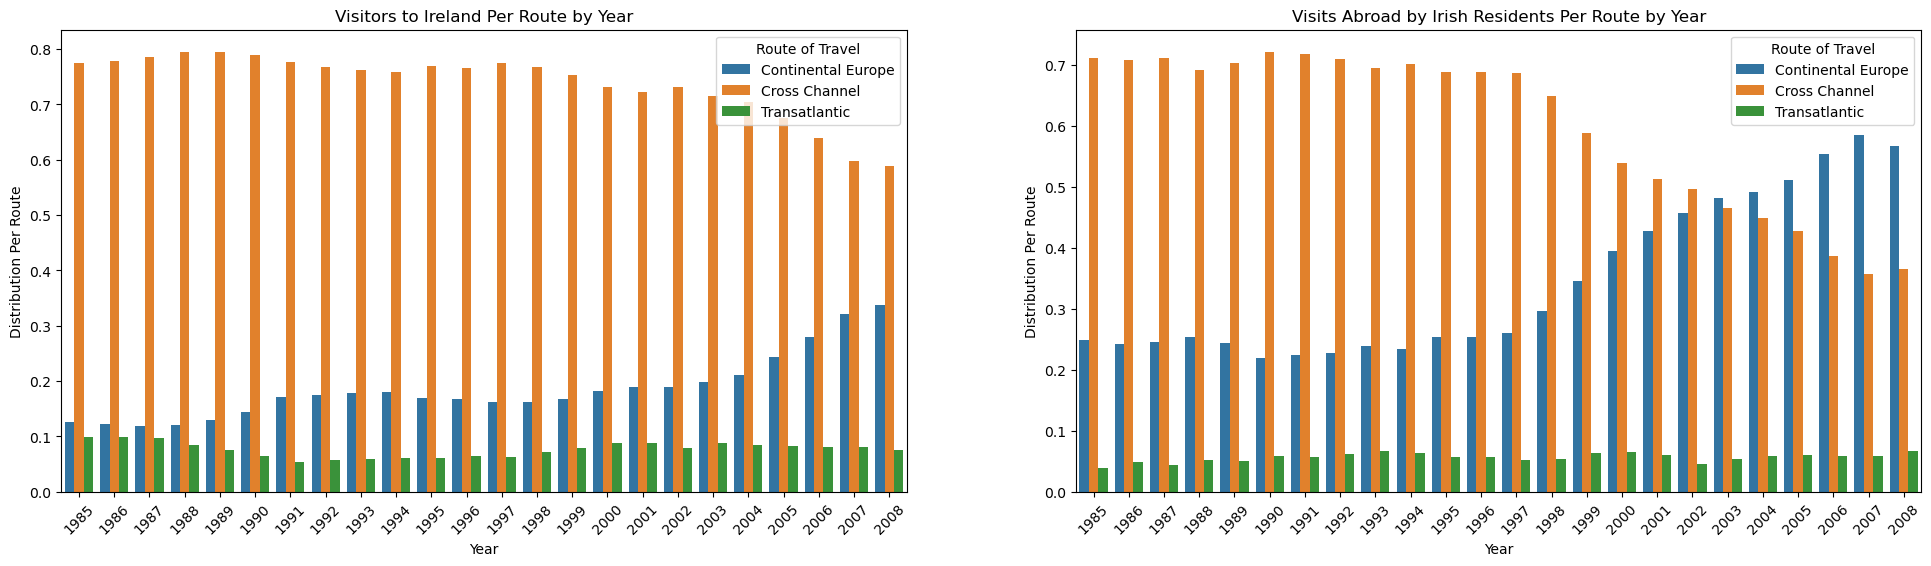

In [413]:
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

sns.barplot(x='Year', y='Distribution Per Route', data=to_ireland_df, hue='Route of Travel', ci=None, ax=axes[0]);
axes[0].set_title(VISITORS_TO_IRELAND + ' Per Route by Year');
axes[0].tick_params(axis='x', rotation=45);
sns.barplot(x='Year', y='Distribution Per Route', data=from_ireland_df, hue='Route of Travel', ci=None, ax=axes[1]);
axes[1].set_title(VISITORS_FROM_IRELAND + ' Per Route by Year');
axes[1].tick_params(axis='x', rotation=45);

## Statistics

In [414]:
#Now we are counting number of days which are sunny within 50 days
df_2008 = to_ireland_df.loc[(to_ireland_df['Year'] == 2008)]
df_2008.head(1)

PROBABILITY=0.311284

# Calculate the probability of k number or fewer visitors in 100 are from Continental Europe when arriving in Q1 of 2008
print('CDF: ', round(binom.cdf(k=15, n=100, p=PROBABILITY)*100, 2))

# Calculate the probability of exactly k number of visitors in 100 are from Continental europe when arriving in Q1 of 2008
print('PMF: ',round(binom.pmf(k=15, n = 100, p =PROBABILITY)*100, 2))

#The probability of more than k number of visitors in 100 are from Continental Europe when arriving in Q1 of 2008
print('SF: ',round(binom.sf(k=15, n = 100, p =PROBABILITY)*100, 2))

,Route of Travel,Year,Quarter,Direction,"Travellers x(1,000)",Distribution Per Route
552,Continental Europe,2008,1,Visitors to Ireland,480,0.311284


CDF:  0.02
PMF:  0.01
SF:  99.98


In [415]:
df_1985 = to_ireland_df.loc[(to_ireland_df['Year'] == 1985)]
df_1985.head(1)

PROBABILITY=0.110236

# Calculate the probability of k number or fewer visitors in 100 are from Continental Europe when arriving in Q1 of 1985
print('CDF: ', round(binom.cdf(k=15, n=100, p=PROBABILITY)*100, 2))

# Calculate the probability of exactly k number of visitors in 100 are from Continental europe when arriving in Q1 of 1985
print('PMF: ', round(binom.pmf(k=15, n = 100, p=PROBABILITY)*100, 2))

#The probability of more than a k number of visitors in 100 are from Continental Europe when arriving in Q1 of 1985
print('SF: ', round(binom.sf(k=15, n = 100, p=PROBABILITY)*100, 2))

,Route of Travel,Year,Quarter,Direction,"Travellers x(1,000)",Distribution Per Route
0,Continental Europe,1985,1,Visitors to Ireland,28,0.110236


CDF:  91.86
PMF:  5.33
SF:  8.14


## Dataset 2: Reason for Travel - Exploration and Cleaning
#### Explore reason dataset
#### Dataset describes travel to and from Ireland by all routes between the years of 1976 and 2008, yearly, with lenght of stay, reason for travel and expenditure .

In [416]:
# Read csv file into pandas dataframe 
# url = https://data.gov.ie/dataset/tma05-visits-to-and-from-ireland/resource/3fe9ec9d-c16f-47dc-92e3-6749c6361d7c

reason_df = pd.read_csv("TMA05-Visits-to-and-from-Ireland.csv")
reason_df.shape
reason_df.head(5)

(792, 8)

,C02118V02559,Reason for Journey,TLIST(A1),Year,STATISTIC,Statistic Label,UNIT,VALUE
0,1,Holiday/leisure/recreation,1976,1976,TMA05C1,Expenditure by Vistors to Ireland,Euro Million,69.0
1,1,Holiday/leisure/recreation,1976,1976,TMA05C2,Visitors to Ireland,Thousand,553.0
2,1,Holiday/leisure/recreation,1976,1976,TMA05C3,Average Length of Stay by Visitors to Ireland,Nights,NaN
3,1,Holiday/leisure/recreation,1976,1976,TMA05C4,Expenditure by Irish Residents Abroad,Euro Million,81.0
4,1,Holiday/leisure/recreation,1976,1976,TMA05C5,Visits Abroad by Irish Residents,Thousand,428.0


In [417]:
reason_df.drop(columns=['C02118V02559', 'TLIST(A1)', 'STATISTIC'], inplace=True)
reason_df.rename(columns={"Statistic Label": "Direction"}, inplace=True)

In [418]:
reason_df['Reason for Journey'].value_counts()
reason_df['Direction'].value_counts()
reason_df['UNIT'].value_counts()
reason_df['VALUE'].isna().sum() # Less than 10% of the data is missing

Reason for Journey
Holiday/leisure/recreation    198
Visit to friends/relatives    198
Business                      198
Other reason for journey      198
Name: count, dtype: int64

Direction
Expenditure by Vistors to Ireland                   132
Visitors to Ireland                                 132
Average Length of Stay by Visitors to Ireland       132
Expenditure by Irish Residents Abroad               132
Visits Abroad by Irish Residents                    132
Average Length of Stay Abroad by Irish Residents    132
Name: count, dtype: int64

UNIT
Euro Million    264
Thousand        264
Nights          264
Name: count, dtype: int64

56

In [419]:
# Extract expenditure data
expenditure_df = reason_df.loc[(reason_df['Direction'] == 'Expenditure by Vistors to Ireland') | (reason_df['Direction'] == 'Expenditure by Irish Residents Abroad')].reset_index(drop=True)

# Extract number of travellers data
travellors_df = reason_df.loc[(reason_df['Direction'] == 'Visitors to Ireland') | (reason_df['Direction'] == 'Visits Abroad by Irish Residents')].reset_index(drop=True)

# Extract average length of stay data
duration_df = reason_df.loc[(reason_df['Direction'] == 'Average Length of Stay by Visitors to Ireland') | (reason_df['Direction'] == 'Average Length of Stay Abroad by Irish Residents')].reset_index(drop=True)

expenditure_df.shape
travellors_df.shape
duration_df.shape

(264, 5)

(264, 5)

(264, 5)

In [420]:
# Renaming column values to enable concatenation of the two datasets
direction_mapping = {'Expenditure by Vistors to Ireland': 'Visitors to Ireland',
                     'Expenditure by Irish Residents Abroad': 'Visits Abroad by Irish Residents',
                     'Average Length of Stay by Visitors to Ireland': 'Visitors to Ireland',
                     'Average Length of Stay Abroad by Irish Residents': 'Visits Abroad by Irish Residents'}

expenditure_df["Direction"]=expenditure_df['Direction'].apply(lambda x: direction_mapping[x])
duration_df["Direction"]=duration_df['Direction'].apply(lambda x: direction_mapping[x])

In [421]:
expenditure_df.rename(columns={"VALUE": "Expenditure (x € Mil)"}, inplace=True)
expenditure_df.drop(columns=['UNIT'], inplace=True)

travellors_df.rename(columns={"VALUE": "Travellers (x 1,000)"}, inplace=True)
travellors_df.drop(columns=['UNIT'], inplace=True)

duration_df.rename(columns={"VALUE": "Avg Length of Stay (x Nights)"}, inplace=True)
duration_df.drop(columns=['UNIT'], inplace=True)

In [422]:
expenditure_df.head()
travellors_df.head()
duration_df.head()

,Reason for Journey,Year,Direction,Expenditure (x € Mil)
0,Holiday/leisure/recreation,1976,Visitors to Ireland,69.0
1,Holiday/leisure/recreation,1976,Visits Abroad by Irish Residents,81.0
2,Holiday/leisure/recreation,1977,Visitors to Ireland,98.0
3,Holiday/leisure/recreation,1977,Visits Abroad by Irish Residents,94.0
4,Holiday/leisure/recreation,1978,Visitors to Ireland,132.0


,Reason for Journey,Year,Direction,"Travellers (x 1,000)"
0,Holiday/leisure/recreation,1976,Visitors to Ireland,553.0
1,Holiday/leisure/recreation,1976,Visits Abroad by Irish Residents,428.0
2,Holiday/leisure/recreation,1977,Visitors to Ireland,665.0
3,Holiday/leisure/recreation,1977,Visits Abroad by Irish Residents,420.0
4,Holiday/leisure/recreation,1978,Visitors to Ireland,838.0


,Reason for Journey,Year,Direction,Avg Length of Stay (x Nights)
0,Holiday/leisure/recreation,1976,Visitors to Ireland,NaN
1,Holiday/leisure/recreation,1976,Visits Abroad by Irish Residents,NaN
2,Holiday/leisure/recreation,1977,Visitors to Ireland,NaN
3,Holiday/leisure/recreation,1977,Visits Abroad by Irish Residents,NaN
4,Holiday/leisure/recreation,1978,Visitors to Ireland,NaN


In [423]:
final_df = travellors_df.merge(expenditure_df, on=['Year', 'Direction', 'Reason for Journey'], how='outer')
final_df = final_df.merge(duration_df, on=['Year', 'Direction', 'Reason for Journey'], how='outer')
final_df = final_df.reindex(columns=['Year', 'Direction', 'Reason for Journey', 'Travellers (x 1,000)', 'Expenditure (x € Mil)', 'Avg Length of Stay (x Nights)'])
pd.set_option('display.max_rows', final_df.shape[0]+1)
final_df.head(5)

,Year,Direction,Reason for Journey,"Travellers (x 1,000)",Expenditure (x € Mil),Avg Length of Stay (x Nights)
0,1976,Visitors to Ireland,Business,188.0,15.0,NaN
1,1976,Visitors to Ireland,Holiday/leisure/recreation,553.0,69.0,NaN
2,1976,Visitors to Ireland,Other reason for journey,75.0,4.0,NaN
3,1976,Visitors to Ireland,Visit to friends/relatives,494.0,43.0,NaN
4,1976,Visits Abroad by Irish Residents,Business,150.0,33.0,NaN


In [424]:
final_df.describe()

,Year,"Travellers (x 1,000)",Expenditure (x € Mil),Avg Length of Stay (x Nights)
count,264.00000,264.000000,264.000000,208.000000
mean,1992.00000,851.609848,462.117424,9.217308
std,9.53999,891.930948,666.849238,3.092720
min,1976.00000,75.000000,4.000000,3.400000
25%,1984.00000,312.000000,99.500000,6.900000
50%,1992.00000,559.500000,252.000000,9.250000
75%,2000.00000,976.250000,521.750000,11.000000
max,2008.00000,4824.000000,4975.000000,23.000000


In [425]:
final_df.dtypes



Year                               int64
Direction                         object
Reason for Journey                object
Travellers (x 1,000)             float64
Expenditure (x € Mil)            float64
Avg Length of Stay (x Nights)    float64
dtype: object

## Displaying Distribution of Features of Visitors to and from Ireland per year

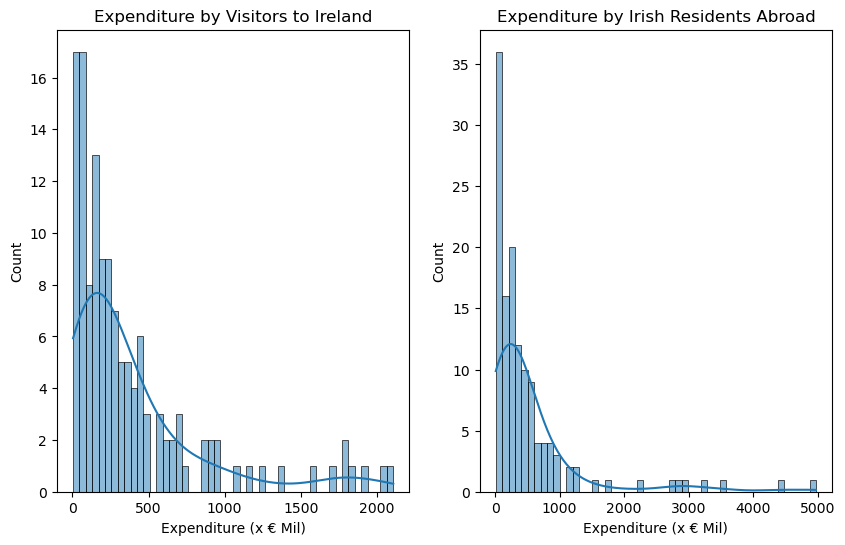

In [426]:
# Assessing distribution of Expenditure by visitors to Ireland and visits abroad by Irish residents summed for all reasons for journey
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

set1 = final_df.loc[final_df['Direction'] == 'Visitors to Ireland']
set2 = final_df.loc[final_df['Direction'] == 'Visits Abroad by Irish Residents']
sns.histplot(data=set1, x='Expenditure (x € Mil)', ax=axes[0], kde=True, bins=50);
sns.histplot(data=set2, x='Expenditure (x € Mil)', ax=axes[1], kde=True, bins=50);
axes[0].set_title('Expenditure by Visitors to Ireland');
axes[1].set_title('Expenditure by Irish Residents Abroad');

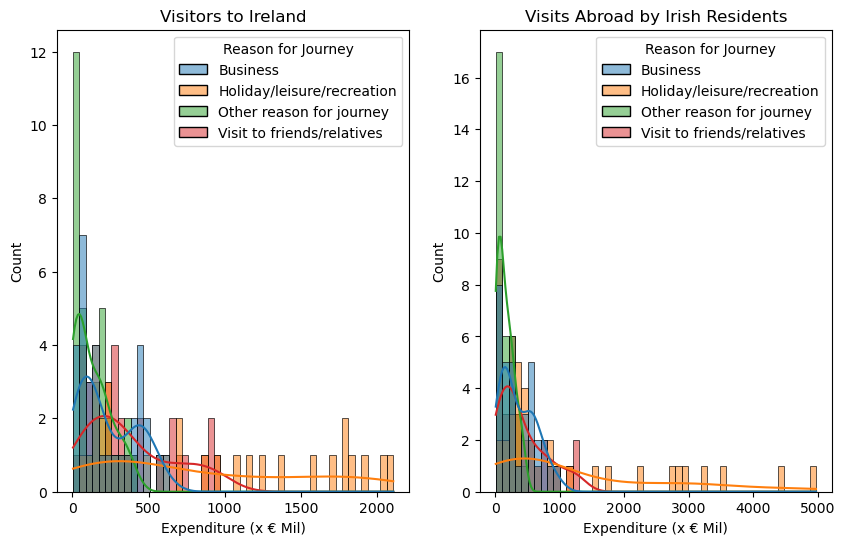

In [427]:
# Assessing distribution of Expenditure by visitors to Ireland and visits abroad by Irish residents broken down by reason for journey

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

set1 = final_df.loc[final_df['Direction'] == 'Visitors to Ireland']
set2 = final_df.loc[final_df['Direction'] == 'Visits Abroad by Irish Residents']
sns.histplot(data=set1, x='Expenditure (x € Mil)', ax=axes[0], kde=True, bins=50, hue='Reason for Journey');
sns.histplot(data=set2, x='Expenditure (x € Mil)', ax=axes[1], kde=True, bins=50, hue='Reason for Journey');
axes[0].set_title('Visitors to Ireland');
axes[1].set_title('Visits Abroad by Irish Residents');

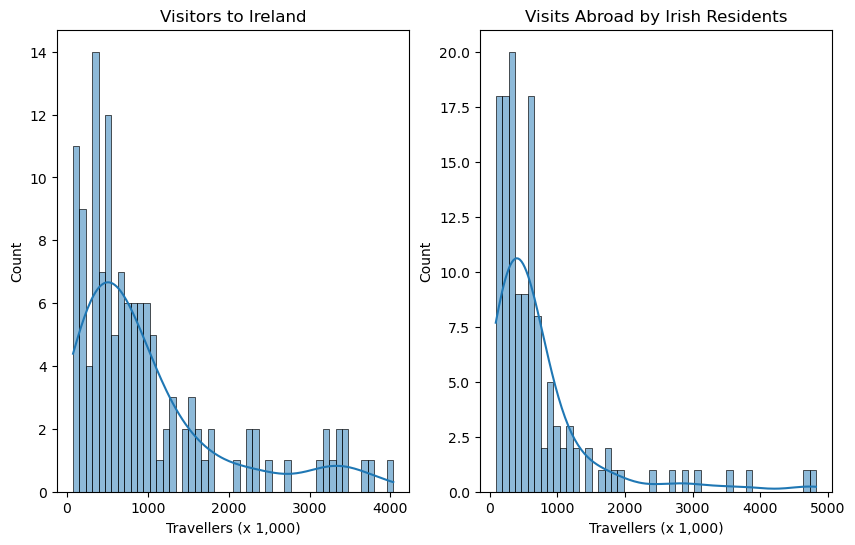

In [428]:
# Assessing distribution of number of travellers to Ireland and visits abroad by Irish residents for all reasons for journey
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

set1 = final_df.loc[final_df['Direction'] == 'Visitors to Ireland']
set2 = final_df.loc[final_df['Direction'] == 'Visits Abroad by Irish Residents']
sns.histplot(data=set1, x='Travellers (x 1,000)', ax=axes[0], kde=True, bins=50);
sns.histplot(data=set2, x='Travellers (x 1,000)', ax=axes[1], kde=True, bins=50);
axes[0].set_title('Visitors to Ireland');
axes[1].set_title('Visits Abroad by Irish Residents');


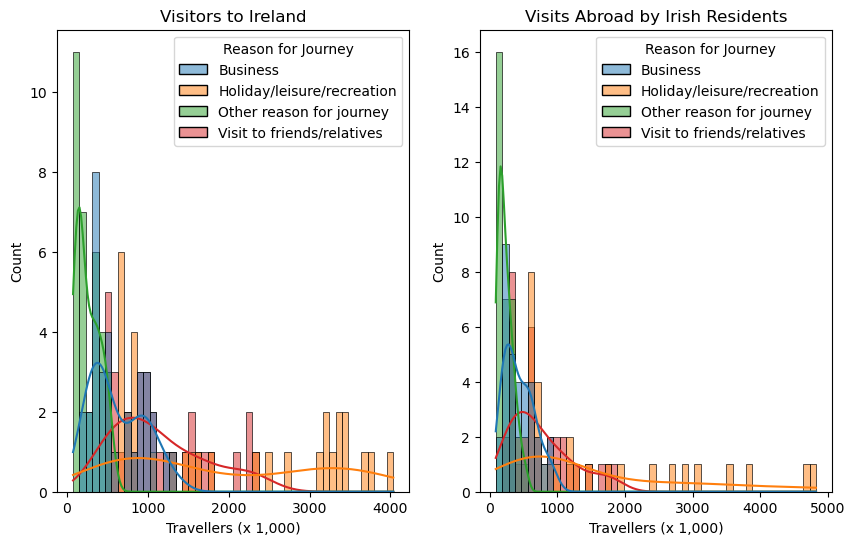

In [429]:
# Assessing distribution of number of travellers to Ireland and visits abroad by Irish residents by reason for journey

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

set1 = final_df.loc[final_df['Direction'] == 'Visitors to Ireland']
set2 = final_df.loc[final_df['Direction'] == 'Visits Abroad by Irish Residents']
sns.histplot(data=set1, x='Travellers (x 1,000)', ax=axes[0], kde=True, bins=50, hue='Reason for Journey');
sns.histplot(data=set2, x='Travellers (x 1,000)', ax=axes[1], kde=True, bins=50, hue='Reason for Journey');
axes[0].set_title('Visitors to Ireland');
axes[1].set_title('Visits Abroad by Irish Residents');

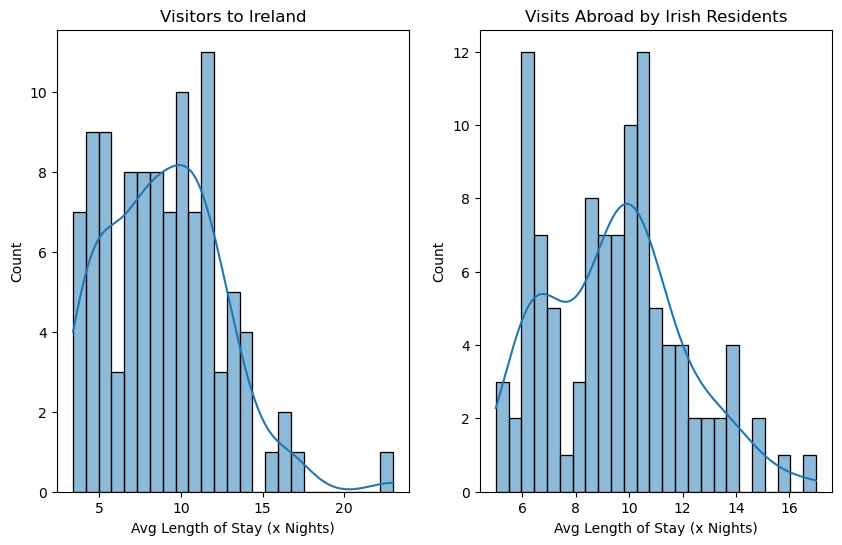

In [430]:
# Assessing distribution of length of stay of visitors to Ireland and visits abroad by Irish residents for all reasons for journey 
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

set1 = final_df.loc[final_df['Direction'] == 'Visitors to Ireland']
set2 = final_df.loc[final_df['Direction'] == 'Visits Abroad by Irish Residents']
sns.histplot(data=set1, x='Avg Length of Stay (x Nights)', ax=axes[0], kde=True, bins=25);
sns.histplot(data=set2, x='Avg Length of Stay (x Nights)', ax=axes[1], kde=True, bins=25);
axes[0].set_title('Visitors to Ireland');
axes[1].set_title('Visits Abroad by Irish Residents');


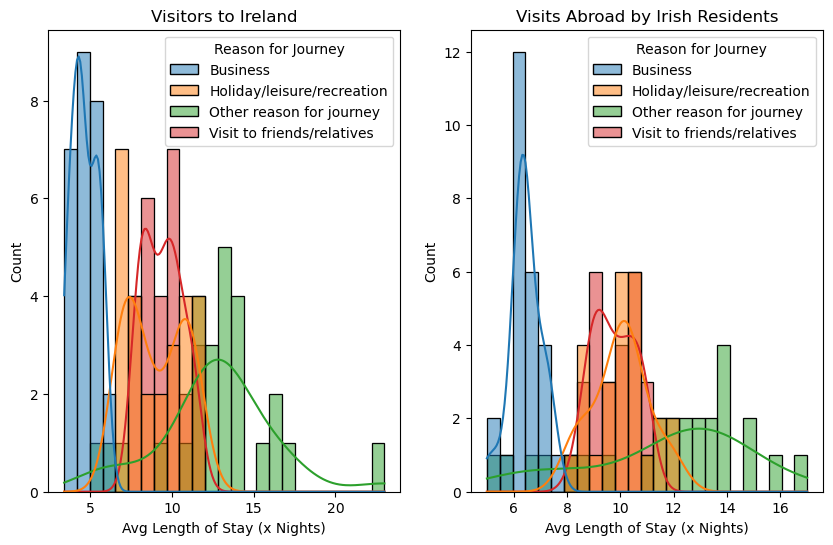

In [431]:
# Assessing distribution of lenght of stay of visitors to Ireland and visits abroad by Irish residents broken down by reason for journey
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

set1 = final_df.loc[final_df['Direction'] == 'Visitors to Ireland']
set2 = final_df.loc[final_df['Direction'] == 'Visits Abroad by Irish Residents']
sns.histplot(data=set1, x='Avg Length of Stay (x Nights)', ax=axes[0], kde=True, bins=25, hue='Reason for Journey');
sns.histplot(data=set2, x='Avg Length of Stay (x Nights)', ax=axes[1], kde=True, bins=25, hue='Reason for Journey');
axes[0].set_title('Visitors to Ireland');
axes[1].set_title('Visits Abroad by Irish Residents');


## Assesing the relationship between variables for visitors to Ireland and visits abroad by Irish residents by reason for journey

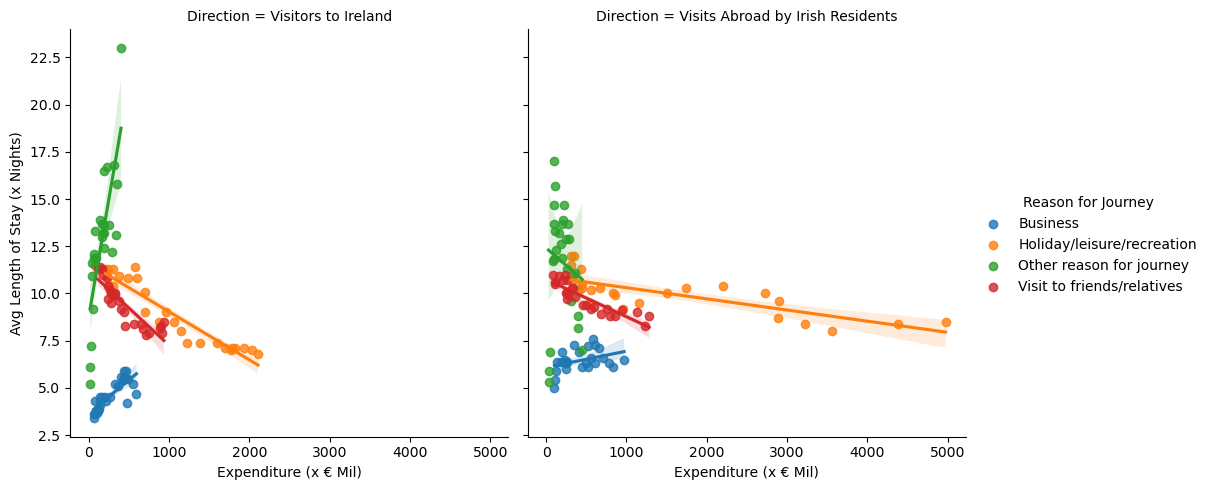

In [432]:
# Lenght of Stay vs Expenditure by visitors to Ireland and visits abroad by Irish residents for all reasons for journey

g = sns.lmplot(
    data=final_df,
    x="Expenditure (x € Mil)", y="Avg Length of Stay (x Nights)",
    height=5, hue="Reason for Journey", col="Direction"
)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Expenditure (x € Mil)", "Avg Length of Stay (x Nights)");

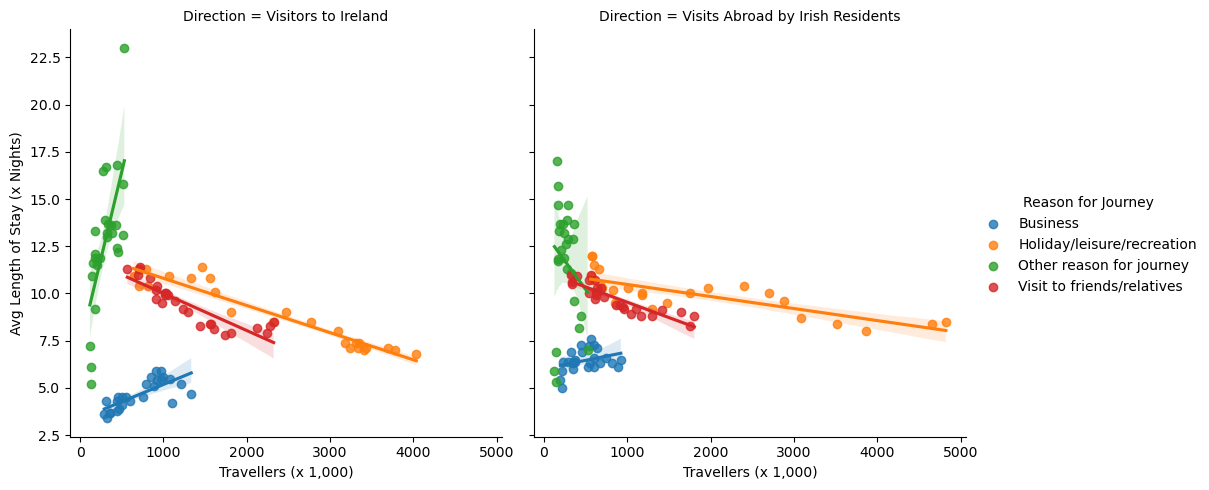

In [433]:
# Lenght of Stay vs Travellors by visitors to Ireland and visits abroad by Irish residents for all reasons for journey

g = sns.lmplot(
    data=final_df,
    x="Travellers (x 1,000)", y="Avg Length of Stay (x Nights)",
    height=5, col="Direction", hue="Reason for Journey"
)

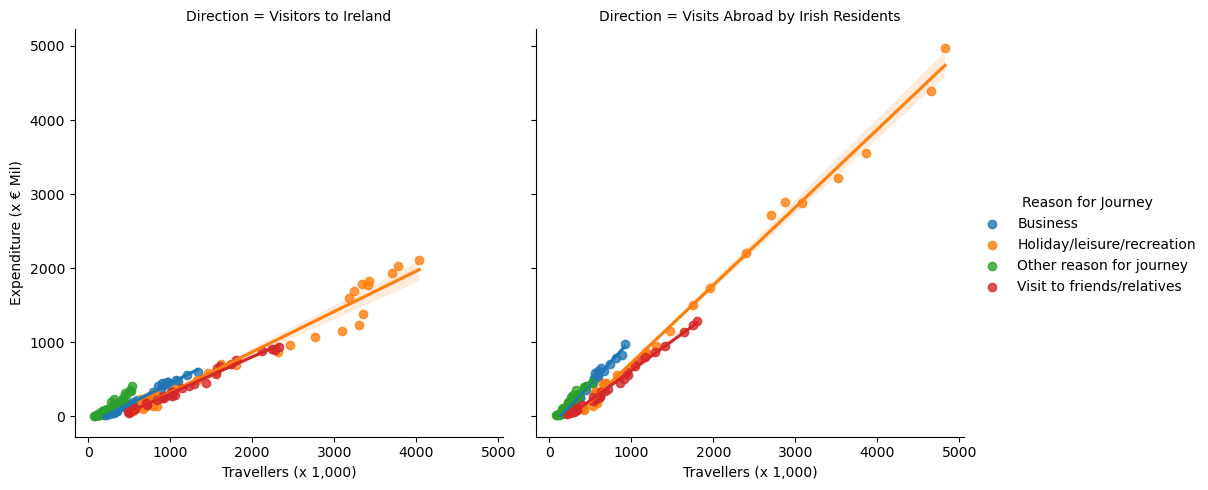

In [434]:
# Expenditure vs Travellers by visitors to Ireland and visits abroad by Irish residents for all reasons for journey

g = sns.lmplot(
    data=final_df,
    x="Travellers (x 1,000)", y="Expenditure (x € Mil)",
    height=5, col="Direction", hue="Reason for Journey",)

### The variables Expenditure and number of travellers are the only variables which demonstrate a positive correlation

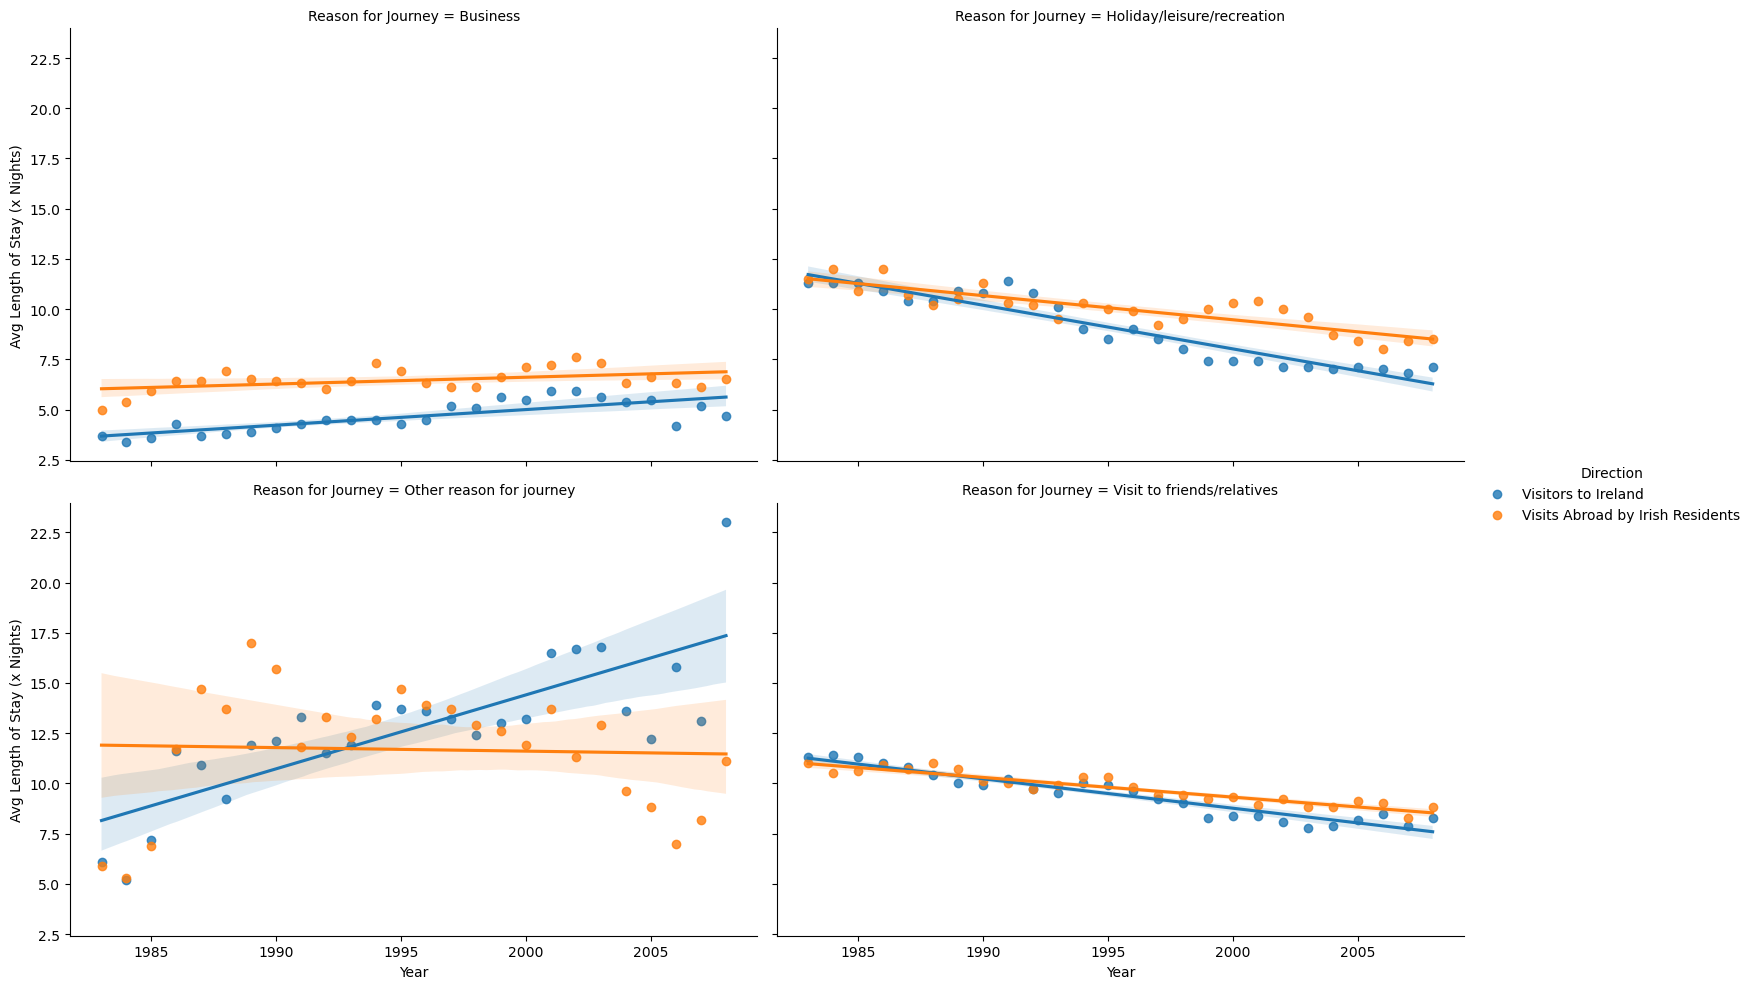

In [435]:
# Assess the annual trend of the average length of stay over the years by reason for journey
g = sns.lmplot(
    data=final_df,
    x="Year", y="Avg Length of Stay (x Nights)",
    height=5, hue= "Direction", col="Reason for Journey", col_wrap=2, aspect=1.5
)

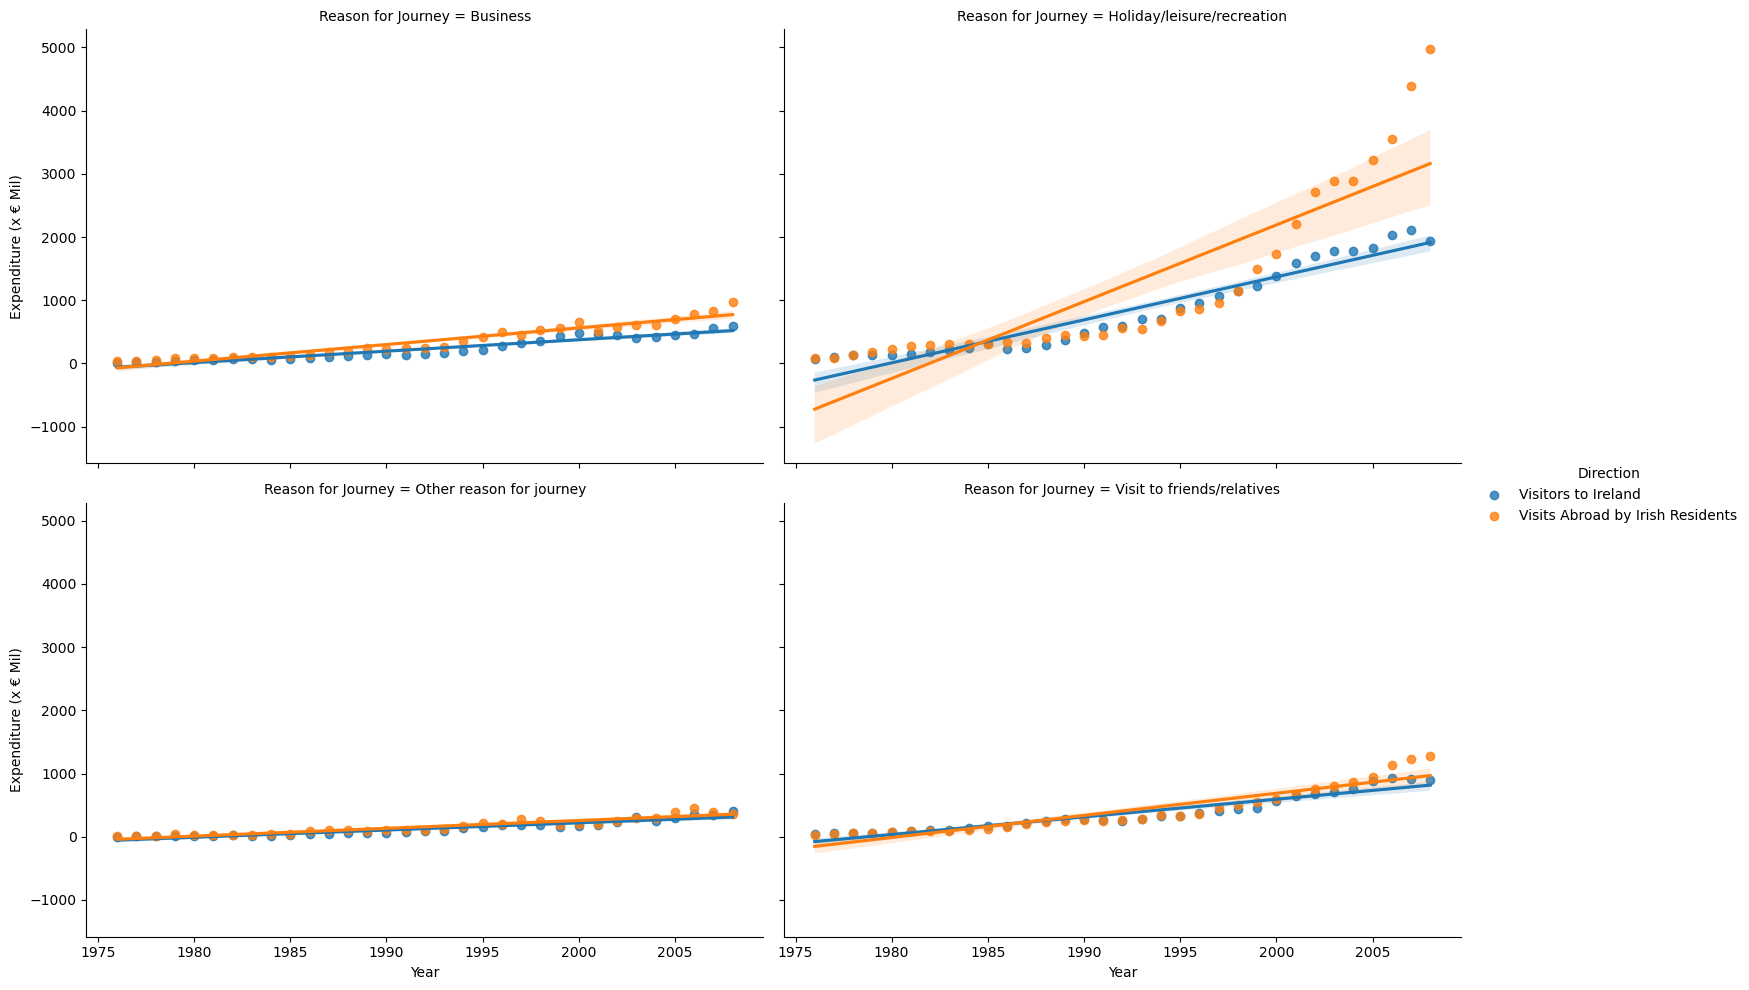

In [436]:
# Assess the annual trend of the Expenditure over the years by reason for journey

g = sns.lmplot(
    data=final_df,
    x="Year", y="Expenditure (x € Mil)",
    height=5, hue='Direction', col='Reason for Journey', col_wrap=2, aspect=1.5
)

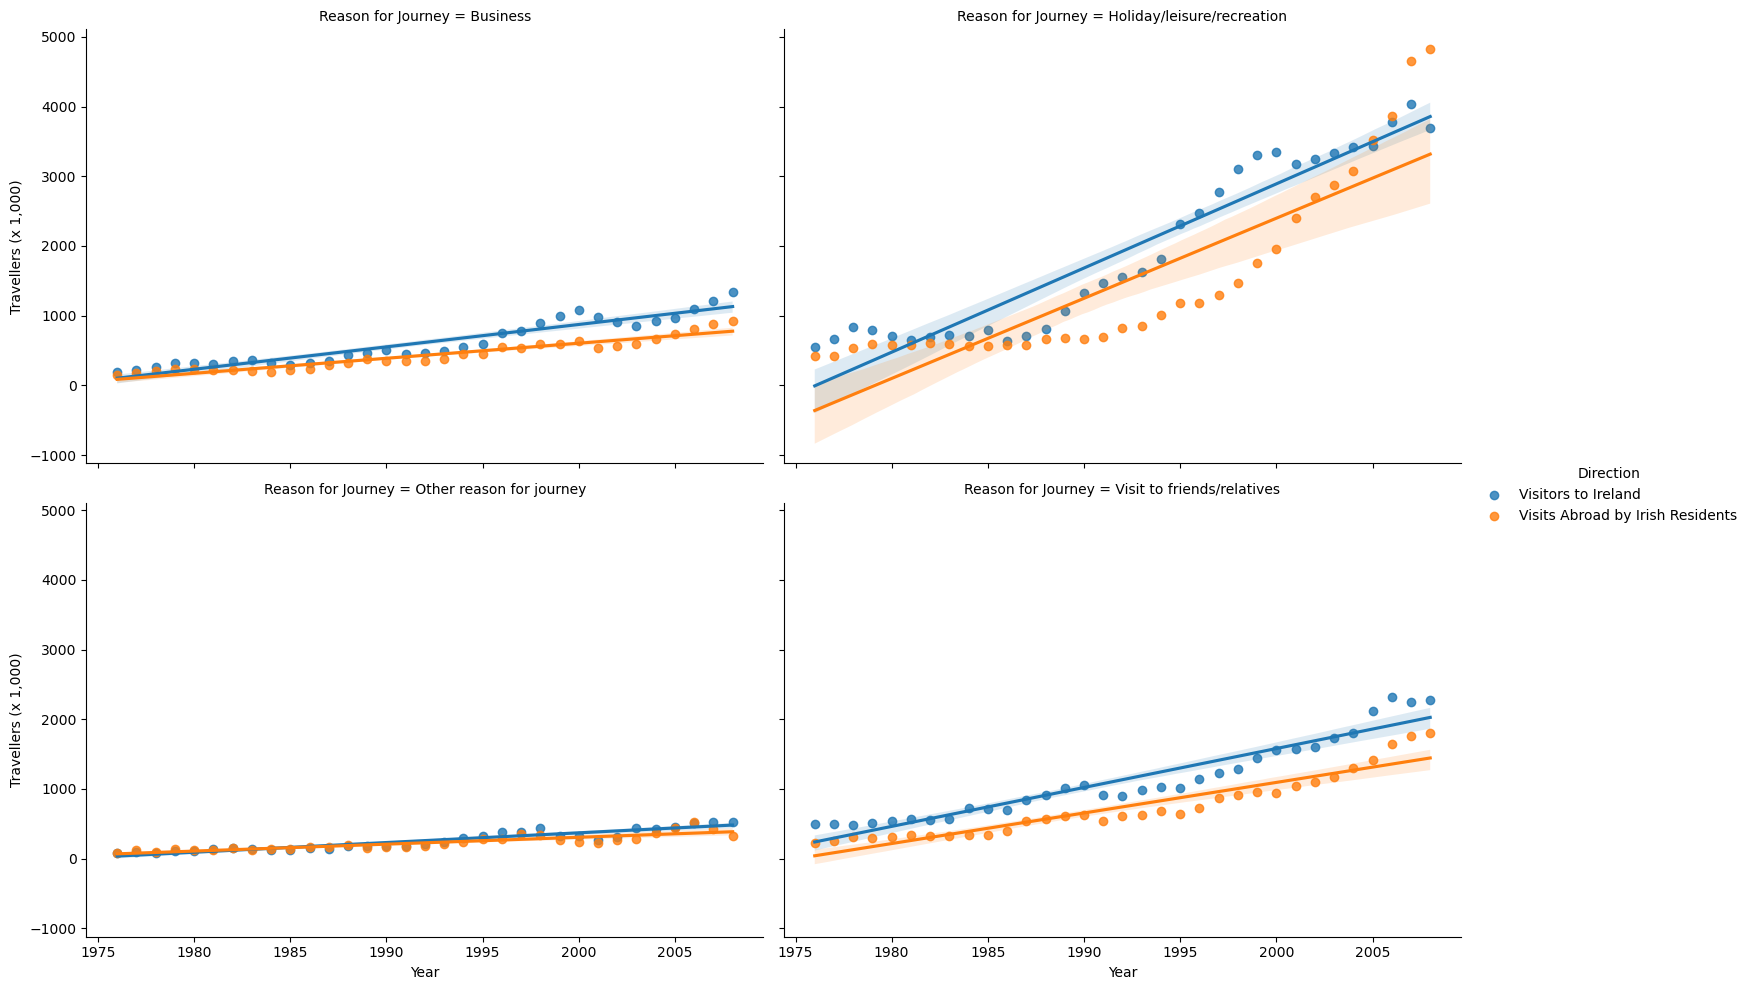

In [437]:
# Assess the annual trend of the number of travellers to and from Ireland over the years by reason for journey

g = sns.lmplot(
    data=final_df,
    x="Year", y="Travellers (x 1,000)",
    height=5, hue="Direction", col="Reason for Journey", col_wrap=2, aspect=1.5
)


## Preprocessing

## Imputing the missing data

In [438]:
from sklearn.impute import KNNImputer

# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Impute missing values in final_df

Univariate imputing - will use the mean as it does not have any additional context

In [439]:
# Just pass in the colum - it imputes with mean value
one_col_impute = pd.DataFrame(imputer.fit_transform(final_df[['Avg Length of Stay (x Nights)']]))
one_col_impute.head(10)

,0
0,9.217308
1,9.217308
2,9.217308
3,9.217308
4,9.217308
5,9.217308
6,9.217308
7,9.217308
8,9.217308
9,9.217308


Try multivariabe imputing, and use all variables. Some variable are categorical, hence I need to first do encoding

### Use Ordinal Encoder and Impute

In [440]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

encoded = enc.fit_transform(final_df[['Direction', 'Reason for Journey']])
encoded_df = pd.DataFrame(encoded, columns=['Direction', 'Reason for Journey'])
encoded_df.head()

final_df_encoded = final_df.copy()
final_df_encoded['Direction'] = encoded_df['Direction']
final_df_encoded['Reason for Journey'] = encoded_df['Reason for Journey']

final_df_encoded.head()

,Direction,Reason for Journey
0,0.0,0.0
1,0.0,1.0
2,0.0,2.0
3,0.0,3.0
4,1.0,0.0


,Year,Direction,Reason for Journey,"Travellers (x 1,000)",Expenditure (x € Mil),Avg Length of Stay (x Nights)
0,1976,0.0,0.0,188.0,15.0,NaN
1,1976,0.0,1.0,553.0,69.0,NaN
2,1976,0.0,2.0,75.0,4.0,NaN
3,1976,0.0,3.0,494.0,43.0,NaN
4,1976,1.0,0.0,150.0,33.0,NaN


In [441]:
final_df_imputed = pd.DataFrame(imputer.fit_transform(final_df_encoded), columns=['Year', 'Direction', 'Reason for Journey', 'Travellers (x 1,000)', 'Expenditure (x € Mil)', 'Avg Length of Stay (x Nights)'])
final_df_imputed.loc[(final_df_imputed['Reason for Journey']==1.0)].head(20)

,Year,Direction,Reason for Journey,"Travellers (x 1,000)",Expenditure (x € Mil),Avg Length of Stay (x Nights)
1,1976.0,0.0,1.0,553.0,69.0,5.66
5,1976.0,1.0,1.0,428.0,81.0,4.04
9,1977.0,0.0,1.0,665.0,98.0,11.26
13,1977.0,1.0,1.0,420.0,94.0,5.48
17,1978.0,0.0,1.0,838.0,132.0,10.72
21,1978.0,1.0,1.0,540.0,136.0,5.66
25,1979.0,0.0,1.0,790.0,140.0,11.16
29,1979.0,1.0,1.0,588.0,185.0,8.28
33,1980.0,0.0,1.0,703.0,142.0,11.26
37,1980.0,1.0,1.0,583.0,223.0,8.04


In [442]:
# I tried to drop the columns for Travellers and Expenditure to see how imputed values changed, but it did not work, perhaps because the use of ordinal encoding for the categorical variables instead onehot encoding, thereby attributing a relational value to the categorical variables, which may have affected the imputation process. I will try again with onehot
imputed_cols_dropped = pd.DataFrame(imputer.fit_transform(final_df_encoded.drop(columns=['Travellers (x 1,000)', 'Expenditure (x € Mil)'])), 
                                    columns=['Year', 'Direction', 'Reason for Journey', 'Avg Length of Stay (x Nights)'])
imputed_cols_dropped.loc[(final_df_imputed['Reason for Journey']==1.0)].head(20)

,Year,Direction,Reason for Journey,Avg Length of Stay (x Nights)
1,1976.0,0.0,1.0,7.52
5,1976.0,1.0,1.0,7.48
9,1977.0,0.0,1.0,7.52
13,1977.0,1.0,1.0,7.48
17,1978.0,0.0,1.0,7.52
21,1978.0,1.0,1.0,7.48
25,1979.0,0.0,1.0,7.52
29,1979.0,1.0,1.0,7.48
33,1980.0,0.0,1.0,7.52
37,1980.0,1.0,1.0,7.48


### Use One Hot encoder

In [443]:
# Try onehot encoding to see if it will work better
onehot_final_df = pd.get_dummies(final_df)
onehot_final_df.head(20)

,Year,"Travellers (x 1,000)",Expenditure (x € Mil),Avg Length of Stay (x Nights),Direction_Visitors to Ireland,Direction_Visits Abroad by Irish Residents,Reason for Journey_Business,Reason for Journey_Holiday/leisure/recreation,Reason for Journey_Other reason for journey,Reason for Journey_Visit to friends/relatives
0,1976,188.0,15.0,NaN,True,False,True,False,False,False
1,1976,553.0,69.0,NaN,True,False,False,True,False,False
2,1976,75.0,4.0,NaN,True,False,False,False,True,False
3,1976,494.0,43.0,NaN,True,False,False,False,False,True
4,1976,150.0,33.0,NaN,False,True,True,False,False,False
5,1976,428.0,81.0,NaN,False,True,False,True,False,False
6,1976,87.0,10.0,NaN,False,True,False,False,True,False
7,1976,222.0,32.0,NaN,False,True,False,False,False,True
8,1977,214.0,20.0,NaN,True,False,True,False,False,False
9,1977,665.0,98.0,NaN,True,False,False,True,False,False


Test 1: One Hot + 1 Column

In [444]:
# Just pass in the colum - it imputes with JUST MEAN value
t1_onehot_mean_df = pd.DataFrame(imputer.fit_transform(onehot_final_df[['Avg Length of Stay (x Nights)']]))
t1_onehot_mean_df.head(10)

,0
0,9.217308
1,9.217308
2,9.217308
3,9.217308
4,9.217308
5,9.217308
6,9.217308
7,9.217308
8,9.217308
9,9.217308


Test 2: Trying to pass the whole dataframe into the Imputer 

In [445]:
# Impute missing values using onehot_final_df
t2_onehot_final_df_imputed = pd.DataFrame(imputer.fit_transform(onehot_final_df), columns=onehot_final_df.columns.to_numpy())
t2_onehot_final_df_imputed.head(10)


,Year,"Travellers (x 1,000)",Expenditure (x € Mil),Avg Length of Stay (x Nights),Direction_Visitors to Ireland,Direction_Visits Abroad by Irish Residents,Reason for Journey_Business,Reason for Journey_Holiday/leisure/recreation,Reason for Journey_Other reason for journey,Reason for Journey_Visit to friends/relatives
0,1976.0,188.0,15.0,8.82,1.0,0.0,1.0,0.0,0.0,0.0
1,1976.0,553.0,69.0,5.66,1.0,0.0,0.0,1.0,0.0,0.0
2,1976.0,75.0,4.0,5.94,1.0,0.0,0.0,0.0,1.0,0.0
3,1976.0,494.0,43.0,5.48,1.0,0.0,0.0,0.0,0.0,1.0
4,1976.0,150.0,33.0,8.16,0.0,1.0,1.0,0.0,0.0,0.0
5,1976.0,428.0,81.0,4.04,0.0,1.0,0.0,1.0,0.0,0.0
6,1976.0,87.0,10.0,5.94,0.0,1.0,0.0,0.0,1.0,0.0
7,1976.0,222.0,32.0,11.60,0.0,1.0,0.0,0.0,0.0,1.0
8,1977.0,214.0,20.0,11.26,1.0,0.0,1.0,0.0,0.0,0.0
9,1977.0,665.0,98.0,11.26,1.0,0.0,0.0,1.0,0.0,0.0


### I think this is the best imputation as it reflects the recurring trends seen in the existing data between reasons for journey and lenght of stay

In [446]:
# By using One-hot encoding of the categorical variables (Direction & Reason for Journey), I avoid imposing an erroneous hierarchy or order to the Categorical Variables allowing 
# the imputation process to fill in the missing values for the numerical variables in Average LEnght of stay for the years from 1976 to 2008.
columns = ['Avg Length of Stay (x Nights)', 'Direction_Visitors to Ireland',
       'Direction_Visits Abroad by Irish Residents',
       'Reason for Journey_Business',
       'Reason for Journey_Holiday/leisure/recreation',
       'Reason for Journey_Other reason for journey',
       'Reason for Journey_Visit to friends/relatives']
columns_to_drop = ['Year', 'Travellers (x 1,000)', 'Expenditure (x € Mil)']

onehot_imputed_df = pd.DataFrame(imputer.fit_transform(onehot_final_df.drop(columns=columns_to_drop)), columns=columns)

# The indexes exactly match and I do not need a column to merge on as I am 'glueing together' the data frame I dropped the columns from
onehot_imputed_df = onehot_final_df[columns_to_drop].merge(onehot_imputed_df, left_index=True, right_index=True)
onehot_imputed_df.head(5)

,Year,"Travellers (x 1,000)",Expenditure (x € Mil),Avg Length of Stay (x Nights),Direction_Visitors to Ireland,Direction_Visits Abroad by Irish Residents,Reason for Journey_Business,Reason for Journey_Holiday/leisure/recreation,Reason for Journey_Other reason for journey,Reason for Journey_Visit to friends/relatives
0,1976,188.0,15.0,4.90,1.0,0.0,1.0,0.0,0.0,0.0
1,1976,553.0,69.0,9.92,1.0,0.0,0.0,1.0,0.0,0.0
2,1976,75.0,4.0,13.12,1.0,0.0,0.0,0.0,1.0,0.0
3,1976,494.0,43.0,9.90,1.0,0.0,0.0,0.0,0.0,1.0
4,1976,150.0,33.0,6.30,0.0,1.0,1.0,0.0,0.0,0.0


***Standard Scaler***

Maintains distribution of all features, but returns negative values


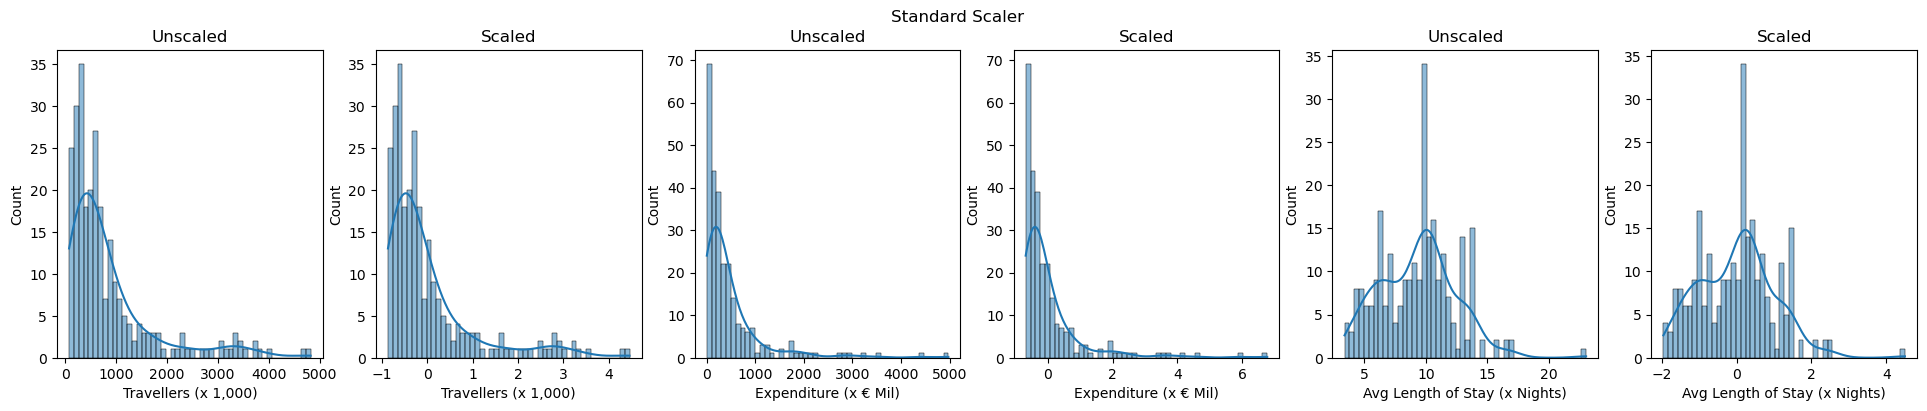

In [447]:
# Scaling the data-Standard Scaler
from sklearn.preprocessing import (MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, Normalizer, QuantileTransformer, PowerTransformer)
scaler = StandardScaler()

columns = ['Travellers (x 1,000)', 'Expenditure (x € Mil)', 'Avg Length of Stay (x Nights)']

scaled_df = scaler.fit_transform(onehot_imputed_df[columns])
scaled_df = pd.DataFrame(scaled_df, columns=columns)
scaled_df.head(5)

fig, axes = plt.subplots(1, 6, figsize=(24, 4))
ind_0 = 0
ind_1= 1
for col in columns:
    _ = sns.histplot(data=onehot_imputed_df, x=col, bins= 50, kde=True, ax=axes[ind_0]); # Putting _ so the function returns into an unnamed variable, otherwise prints into console
    _ = sns.histplot(data=scaled_df, x=col, bins= 50, kde=True, ax=axes[ind_1]);
    _ = axes[ind_0].set_title('Unscaled');
    _ = axes[ind_1].set_title('Scaled');
    ind_0 += 2
    ind_1 += 2
fig.suptitle('Standard Scaler');    
plt.show();

***MinMAx Scaler***

Maintains distribution of all features, with all values between 0 and 1.

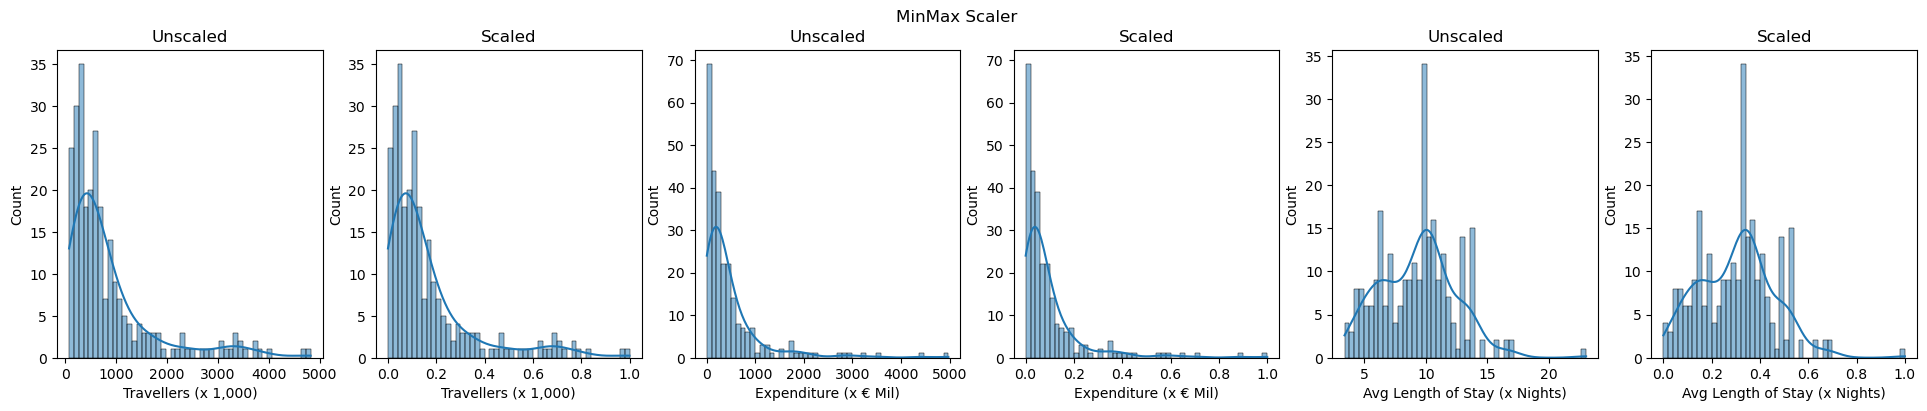

In [448]:
# Scaling the data-MinMax Scaler
scaler = MinMaxScaler()

columns = ['Travellers (x 1,000)', 'Expenditure (x € Mil)', 'Avg Length of Stay (x Nights)']

scaled_df = scaler.fit_transform(onehot_imputed_df[columns])
scaled_df = pd.DataFrame(scaled_df, columns=columns)
scaled_df.head(5)

fig, axes = plt.subplots(1, 6, figsize=(24, 4))
ind_0 = 0
ind_1= 1
for col in columns:
    _ = sns.histplot(data=onehot_imputed_df, x=col, bins= 50, kde=True, ax=axes[ind_0]); # Putting _ so the function returns into an unnamed variable, otherwise prints into console
    _ = sns.histplot(data=scaled_df, x=col, bins= 50, kde=True, ax=axes[ind_1]);
    _ = axes[ind_0].set_title('Unscaled');
    _ = axes[ind_1].set_title('Scaled');
    ind_0 += 2
    ind_1 += 2
fig.suptitle('MinMax Scaler');    
plt.show();

***Robust Scaler***

Maintains distribution of all features, but returns negative values

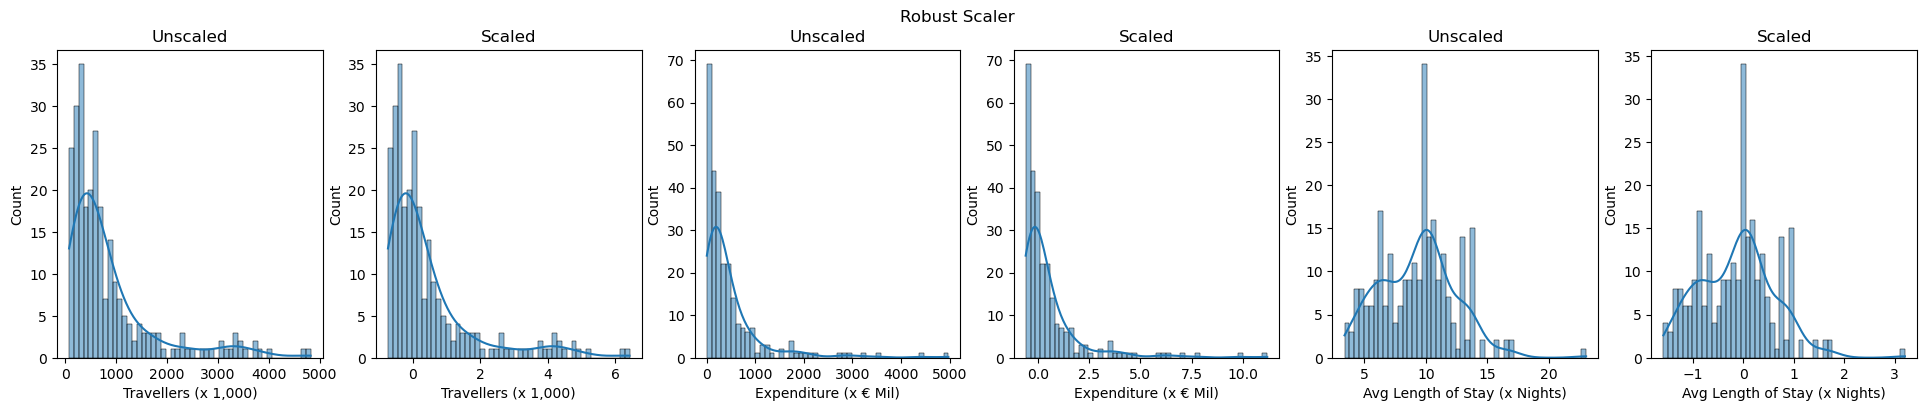

In [449]:
# Scaling the data-Robust Scaler
scaler = RobustScaler()

columns = ['Travellers (x 1,000)', 'Expenditure (x € Mil)', 'Avg Length of Stay (x Nights)']

scaled_df = scaler.fit_transform(onehot_imputed_df[columns])
scaled_df = pd.DataFrame(scaled_df, columns=columns)
scaled_df.head(5)

fig, axes = plt.subplots(1, 6, figsize=(24, 4))
ind_0 = 0
ind_1= 1
for col in columns:
    _ = sns.histplot(data=onehot_imputed_df, x=col, bins= 50, kde=True, ax=axes[ind_0]); # Putting _ so the function returns into an unnamed variable, otherwise prints into console
    _ = sns.histplot(data=scaled_df, x=col, bins= 50, kde=True, ax=axes[ind_1]);
    _ = axes[ind_0].set_title('Unscaled');
    _ = axes[ind_1].set_title('Scaled');
    ind_0 += 2
    ind_1 += 2
fig.suptitle('Robust Scaler');    
plt.show();

***Max Absolute Value Scaler***

Maintains distribution of all features, as no significant outliers

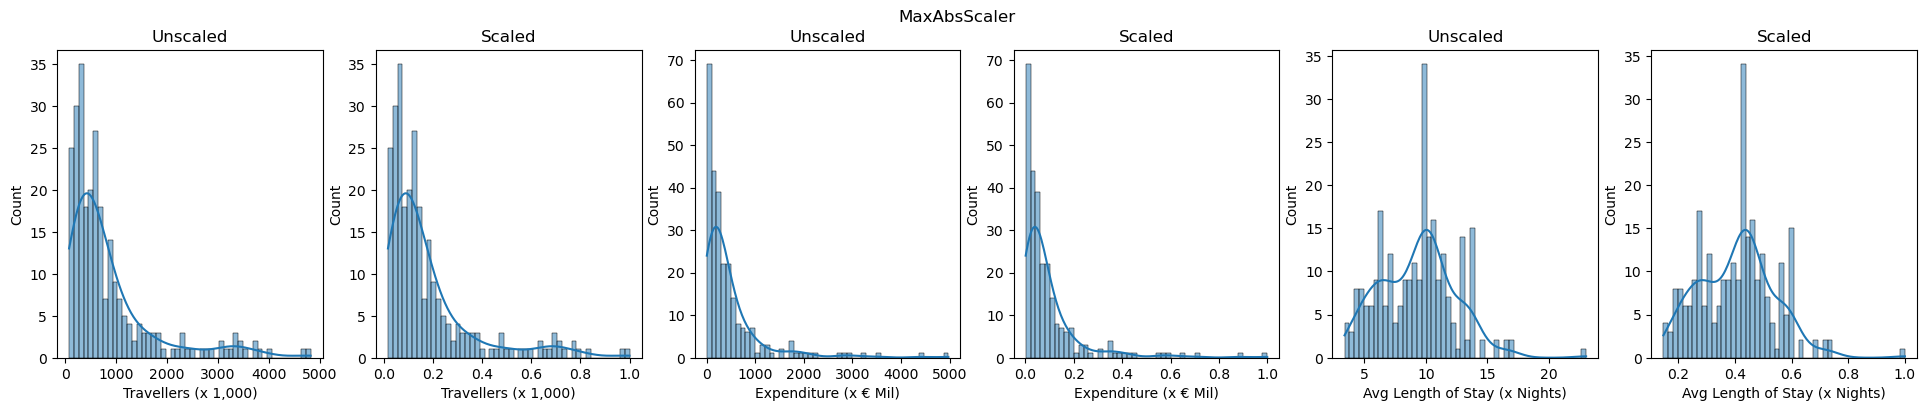

In [450]:
# Scaling the data-MaxAbsScaler
scaler = MaxAbsScaler()

columns = ['Travellers (x 1,000)', 'Expenditure (x € Mil)', 'Avg Length of Stay (x Nights)']

scaled_df = scaler.fit_transform(onehot_imputed_df[columns])
scaled_df = pd.DataFrame(scaled_df, columns=columns)
scaled_df.head(5)

fig, axes = plt.subplots(1, 6, figsize=(24, 4))
ind_0 = 0
ind_1= 1
for col in columns:
    _ = sns.histplot(data=onehot_imputed_df, x=col, bins= 50, kde=True, ax=axes[ind_0]); # Putting _ so the function returns into an unnamed variable, otherwise prints into console
    _ = sns.histplot(data=scaled_df, x=col, bins= 50, kde=True, ax=axes[ind_1]);
    _ = axes[ind_0].set_title('Unscaled');
    _ = axes[ind_1].set_title('Scaled');
    ind_0 += 2
    ind_1 += 2
fig.suptitle('MaxAbsScaler');    
plt.show();

***Normalizer***

Changes distribution of all features

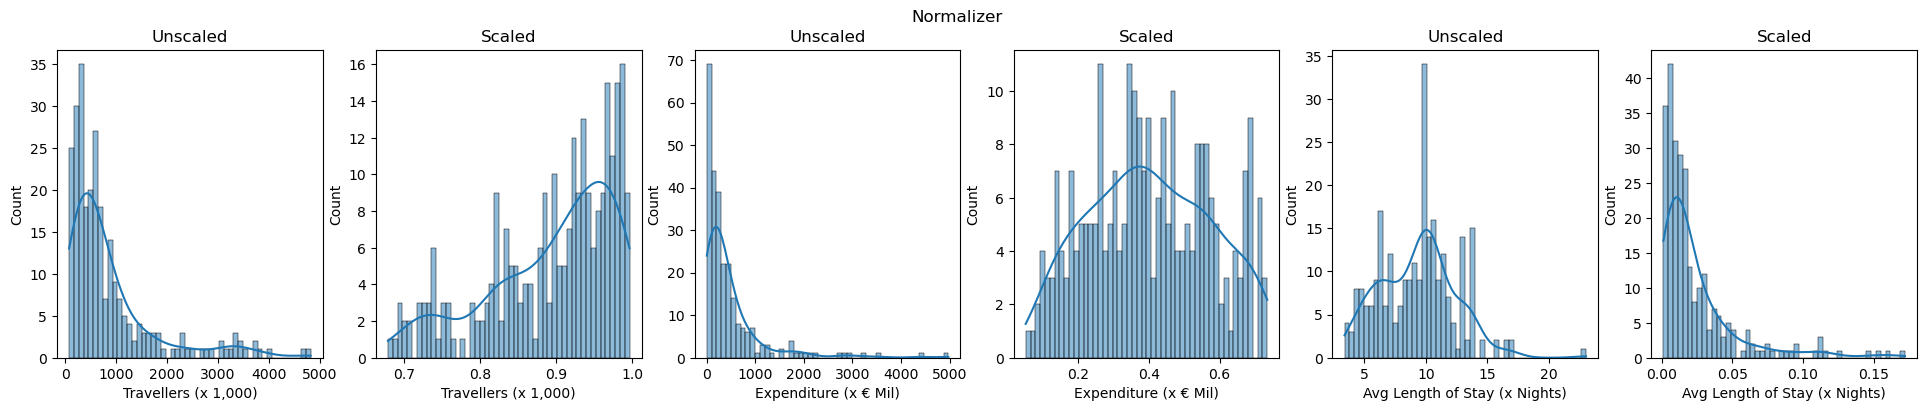

In [451]:
# Scaling the data-Normalizer
scaler = Normalizer()

columns = ['Travellers (x 1,000)', 'Expenditure (x € Mil)', 'Avg Length of Stay (x Nights)']

scaled_df = scaler.fit_transform(onehot_imputed_df[columns])
scaled_df = pd.DataFrame(scaled_df, columns=columns)
scaled_df.head(5)

fig, axes = plt.subplots(1, 6, figsize=(24, 4))
ind_0 = 0
ind_1= 1
for col in columns:
    _ = sns.histplot(data=onehot_imputed_df, x=col, bins= 50, kde=True, ax=axes[ind_0]); # Putting _ so the function returns into an unnamed variable, otherwise prints into console
    _ = sns.histplot(data=scaled_df, x=col, bins= 50, kde=True, ax=axes[ind_1]);
    _ = axes[ind_0].set_title('Unscaled');
    _ = axes[ind_1].set_title('Scaled');
    ind_0 += 2
    ind_1 += 2
fig.suptitle('Normalizer');    
plt.show();

***Power Transformer***

Changes distribution of non Gaussian features

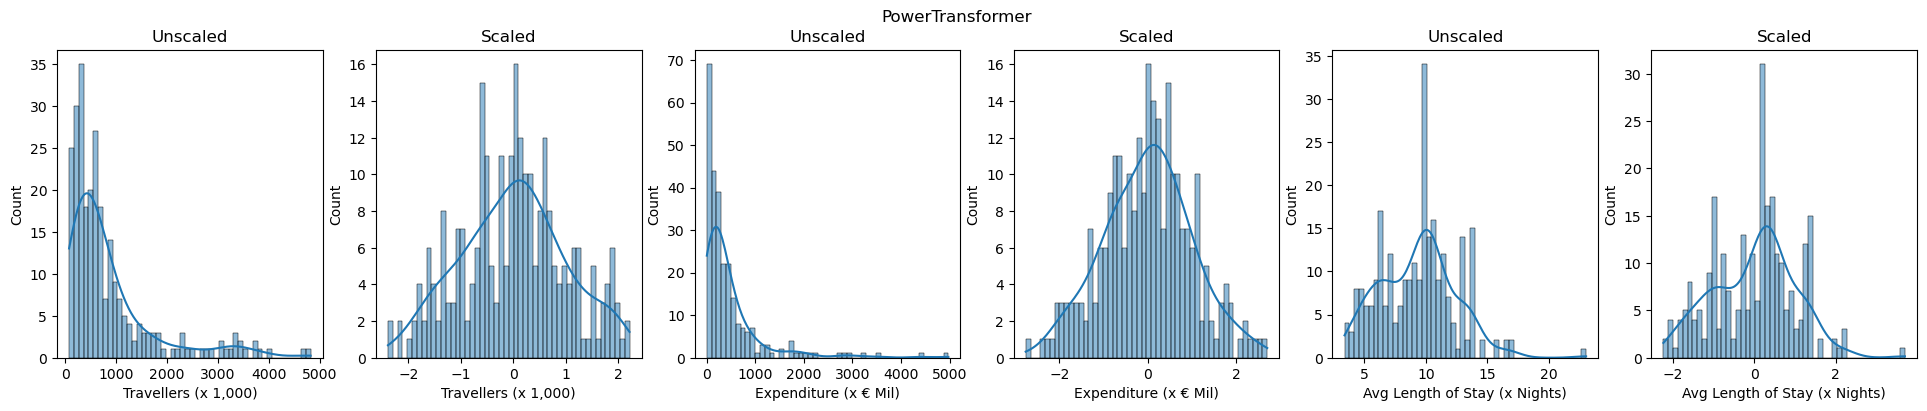

In [452]:
# Scaling the data-PowerTransformer
from sklearn.preprocessing import (MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, Normalizer, QuantileTransformer, PowerTransformer)
scaler = PowerTransformer()

columns = ['Travellers (x 1,000)', 'Expenditure (x € Mil)', 'Avg Length of Stay (x Nights)']

scaled_df = scaler.fit_transform(onehot_imputed_df[columns])
scaled_df = pd.DataFrame(scaled_df, columns=columns)
scaled_df.head(5)

fig, axes = plt.subplots(1, 6, figsize=(24, 4))
ind_0 = 0
ind_1= 1
for col in columns:
    _ = sns.histplot(data=onehot_imputed_df, x=col, bins= 50, kde=True, ax=axes[ind_0]); # Putting _ so the function returns into an unnamed variable, otherwise prints into console
    _ = sns.histplot(data=scaled_df, x=col, bins= 50, kde=True, ax=axes[ind_1]);
    _ = axes[ind_0].set_title('Unscaled');
    _ = axes[ind_1].set_title('Scaled');
    ind_0 += 2
    ind_1 += 2
fig.suptitle('PowerTransformer');    
plt.show();

# ***Machine Learning***
Running SVM model with reason for journey as the target/dependant variable and 6 features/independant variables

In [453]:

onehot_imputed_df.head(5)
onehot_imputed_df.columns.to_numpy()

,Year,"Travellers (x 1,000)",Expenditure (x € Mil),Avg Length of Stay (x Nights),Direction_Visitors to Ireland,Direction_Visits Abroad by Irish Residents,Reason for Journey_Business,Reason for Journey_Holiday/leisure/recreation,Reason for Journey_Other reason for journey,Reason for Journey_Visit to friends/relatives
0,1976,188.0,15.0,4.90,1.0,0.0,1.0,0.0,0.0,0.0
1,1976,553.0,69.0,9.92,1.0,0.0,0.0,1.0,0.0,0.0
2,1976,75.0,4.0,13.12,1.0,0.0,0.0,0.0,1.0,0.0
3,1976,494.0,43.0,9.90,1.0,0.0,0.0,0.0,0.0,1.0
4,1976,150.0,33.0,6.30,0.0,1.0,1.0,0.0,0.0,0.0


array(['Year', 'Travellers (x 1,000)', 'Expenditure (x € Mil)',
       'Avg Length of Stay (x Nights)', 'Direction_Visitors to Ireland',
       'Direction_Visits Abroad by Irish Residents',
       'Reason for Journey_Business',
       'Reason for Journey_Holiday/leisure/recreation',
       'Reason for Journey_Other reason for journey',
       'Reason for Journey_Visit to friends/relatives'], dtype=object)

In [454]:
# Separate the data into features and target
def get_X_y(features):
    X = onehot_imputed_df[features]
    y = final_df['Reason for Journey']

    X.head(4)
    y.head(4)

    X.shape
    y.shape

    # Encoding the target variable labels
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)

    from sklearn.model_selection import train_test_split

    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 82)

    # Display the rows and coulmns of X, y, X_train, y_train, X_test, y_test
    X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

    return X_train, y_train, X_test, y_test

### Defining all Features for test/train split

In [455]:

FEATURES = ['Year', 'Travellers (x 1,000)', 'Expenditure (x € Mil)',
                            'Avg Length of Stay (x Nights)', 'Direction_Visitors to Ireland',
                            'Direction_Visits Abroad by Irish Residents']

X_train, y_train, X_test, y_test = get_X_y(FEATURES)

### Apply selected scaler for test and train data -  selected MinMax Scaler

In [502]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.tolist())
print(X_test.tolist())
print(y_train.tolist())
print(y_test.tolist())

[[0.5, 0.02583753010729144, 0.016902695294655094, 0.41326530612244905, 1.0, 0.0], [0.15625, 0.01029121961900591, 0.002055733211512106, 0.49591836734693884, 1.0, 0.0], [0.0625, 0.09918984015765273, 0.028780264961169484, 0.36428571428571427, 0.0, 1.0], [0.65625, 0.25049266476899495, 0.0897670169026953, 0.29591836734693877, 1.0, 0.0], [0.65625, 0.06415590102912196, 0.039744175422567384, 0.5, 1.0, 0.0], [0.34375, 0.018392818042478647, 0.021242576518958427, 0.576530612244898, 0.0, 1.0], [0.21875, 0.13860302167724986, 0.04522613065326633, 0.403061224489796, 1.0, 0.0], [0.1875, 0.05101817385592293, 0.01735952489721334, 0.3306122448979592, 0.0, 1.0], [0.875, 0.26472520253996057, 0.1946094106898127, 0.27551020408163274, 0.0, 1.0], [0.875, 0.1837092183052332, 0.09456372772955687, 0.10204081632653064, 1.0, 0.0], [0.75, 0.18808846069629956, 0.13430790315212426, 0.30102040816326536, 0.0, 1.0], [0.71875, 0.19071600613093936, 0.12448606669712198, 0.29591836734693877, 0.0, 1.0], [0.96875, 1.0, 1.0, 0.

## Helper Functions
Can have all functions which can be repeated for different models

In [457]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sklearn
from sklearn import svm, metrics


REASON_LABELS=['Business','Holiday','Other', 'Friends/Relatives']

def predict_and_create_CM(classifier, X_test, y_test):
    if isinstance(classifier, sklearn.model_selection._search.GridSearchCV):
        print('Best parameters:', classifier.best_params_)
    
    predictions = classifier.predict(X_test)
    print("Accuracy:", metrics.accuracy_score(y_test, predictions))

    cm = confusion_matrix(y_test, predictions)
    cmd = ConfusionMatrixDisplay(cm, display_labels=REASON_LABELS)
    cmd.plot(cmap='Reds')

    print('Report:\n', classification_report(y_test, predictions));


# https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn 
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

# Manually testing SVM with different function kernels

### Testing RBF kernel with all features

SVC(random_state=0)

Accuracy: 0.7358490566037735
Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.64      0.64      0.64        11
           2       1.00      0.67      0.80        18
           3       0.36      0.56      0.43         9

    accuracy                           0.74        53
   macro avg       0.73      0.71      0.71        53
weighted avg       0.80      0.74      0.75        53



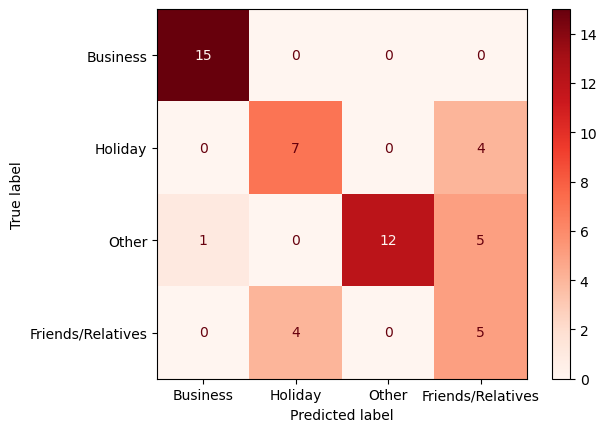

In [458]:
from sklearn.svm import SVC
svc_classifier = SVC(kernel = 'rbf', random_state = 0)
svc_classifier.fit(X_train, y_train)

predict_and_create_CM(svc_classifier, X_test, y_test)

### Run SVM with linear function kernel - Gives better precision and recall

SVC(kernel='linear', random_state=0)

Accuracy: 0.8679245283018868
Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.55      0.71        11
           2       1.00      0.89      0.94        18
           3       0.60      1.00      0.75         9

    accuracy                           0.87        53
   macro avg       0.88      0.86      0.84        53
weighted avg       0.91      0.87      0.87        53



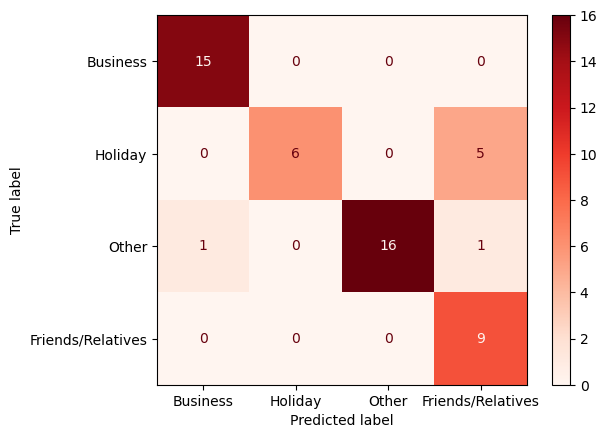

In [459]:
svc_classifier_lin = SVC(kernel = 'linear', random_state = 0)
svc_classifier_lin.fit(X_train, y_train)

predict_and_create_CM(svc_classifier_lin, X_test, y_test)


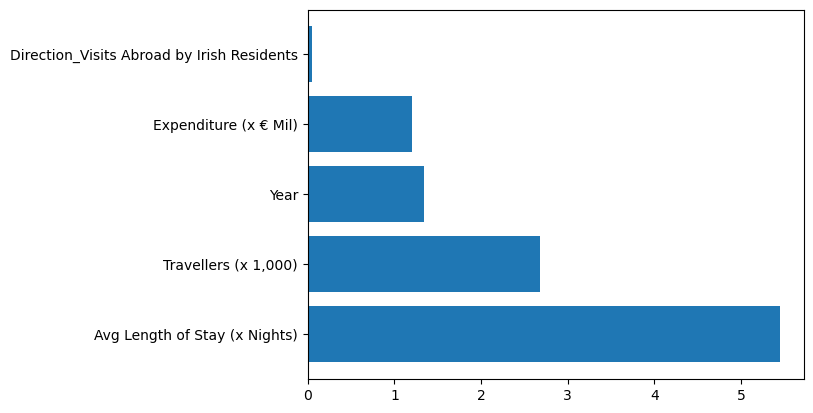

In [460]:

f_importances(abs(svc_classifier_lin.coef_[0]), FEATURES, top=5)
#print(m.coef_)

## Repeat SVM with rbf and linear function kernel but remove year from features to see if it gives better precision and recall

**Without Year**: Defining Features for test/train split without Year

In [461]:
FEATURES_NO_YEAR = ['Travellers (x 1,000)', 'Expenditure (x € Mil)',
                            'Avg Length of Stay (x Nights)', 'Direction_Visitors to Ireland',
                            'Direction_Visits Abroad by Irish Residents']

X_train_no_year, y_train_no_year, X_test_no_year, y_test_no_year = get_X_y(FEATURES_NO_YEAR)

SVC(random_state=0)

Accuracy: 0.5094339622641509
Report:
               precision    recall  f1-score   support

           0       0.38      0.33      0.36        15
           1       1.00      0.36      0.53        11
           2       0.54      0.83      0.65        18
           3       0.38      0.33      0.35         9

    accuracy                           0.51        53
   macro avg       0.57      0.47      0.47        53
weighted avg       0.56      0.51      0.49        53



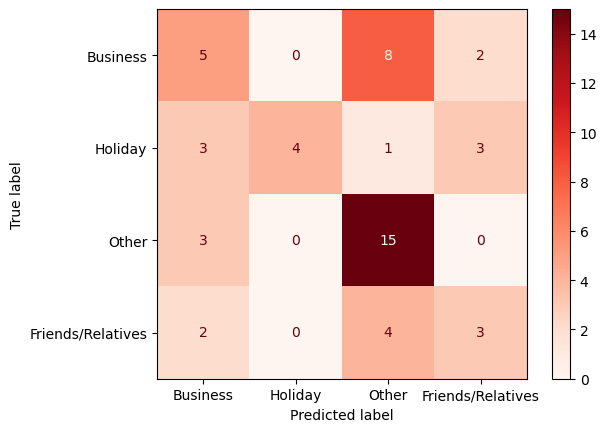

In [462]:
svc_classifier = SVC(kernel = 'rbf', random_state = 0)
svc_classifier.fit(X_train_no_year, y_train_no_year)

predict_and_create_CM(svc_classifier, X_test_no_year, y_test_no_year)

SVC(kernel='linear', random_state=0)

Accuracy: 0.8301886792452831
Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.86      0.55      0.67        11
           2       0.86      1.00      0.92        18
           3       0.50      0.56      0.53         9

    accuracy                           0.83        53
   macro avg       0.80      0.78      0.78        53
weighted avg       0.84      0.83      0.82        53



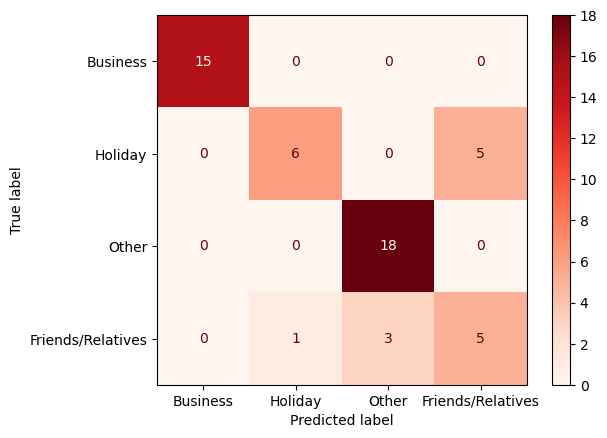

In [463]:
svc_classifier = SVC(kernel = 'linear', random_state = 0)
svc_classifier.fit(X_train_no_year, y_train_no_year)

predict_and_create_CM(svc_classifier, X_test_no_year, y_test_no_year)

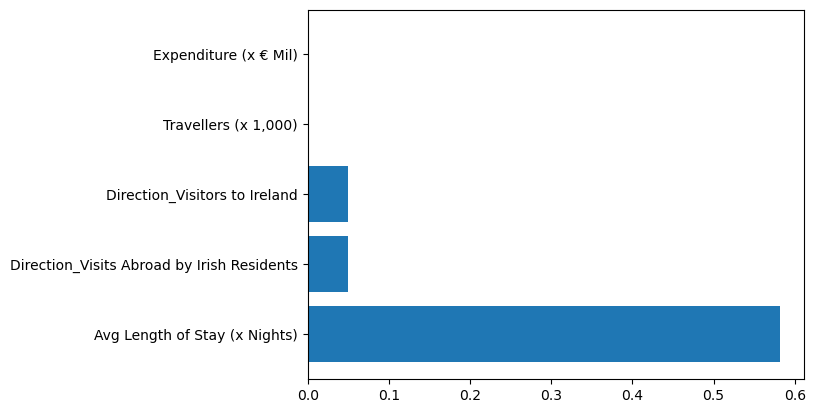

In [464]:
f_importances(abs(svc_classifier.coef_[0]), FEATURES_NO_YEAR, top=5)
#print(m.coef_)

## SVM Parameter Tuning - C, gamma, kernel

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.001],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
             verbose=1)

Best parameters: {'C': 1000, 'gamma': 1, 'kernel': 'poly'}
Accuracy: 1.0
Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00         9

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53



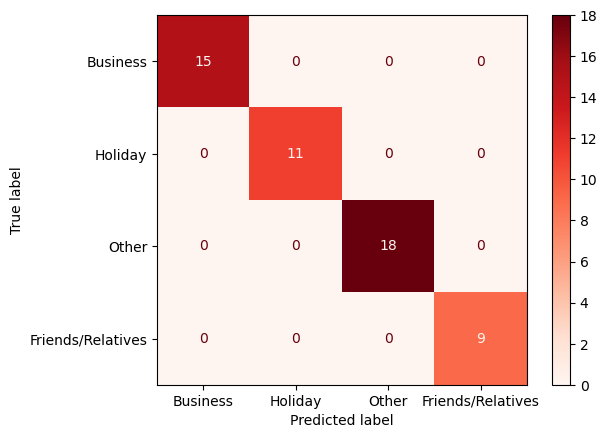

In [465]:
#find best hyper parameters
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.1,1,10,100,1000],'gamma':[1,0.1,0.01,0.001,0.001], 'kernel':['rbf','linear','poly','sigmoid']}
grid = GridSearchCV(SVC(),param_grid,verbose = 1)
grid.fit(X_train,y_train)

predict_and_create_CM(grid, X_test, y_test)

In [466]:
## TO DO: Repeat SVM with optimized hyperparameters on full dataset to get best score for SVM model before moving on to other models.

## Selecting the best Machine Learning Model
Trying top ranked features ("Travellers (x 1,000) & Avg Length of Stay (x Nights)") across different machine learning models.

In [484]:
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

In [489]:
def plot_decision_regions_multi_model(X_viz, y_viz):
    # Initializing different classification tools
    clf1 = LogisticRegression(random_state=0)
    clf2 = RandomForestClassifier(random_state=0)
    clf3 = SVC(random_state=0, kernel='poly', probability=True) # Using optimal hyperparamenters for SVM from preious GridSearch for SVM
    eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[2, 1, 1], voting='soft')
    
    # Plotting Decision Regions
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(12, 9))

    for clf, lab, grd in zip([clf1, clf2, clf3, eclf],
                            ['Logistic Regression', 'Random Forest', 'SVM', 'Ensemble'],
                            itertools.product([0, 1], repeat=2)):
        clf.fit(X_viz, y_viz)
        ax = plt.subplot(gs[grd[0], grd[1]])
        fig = plot_decision_regions(X=X_viz, y=y_viz, clf=clf, legend=2)
        plt.title(lab)
    plt.show();

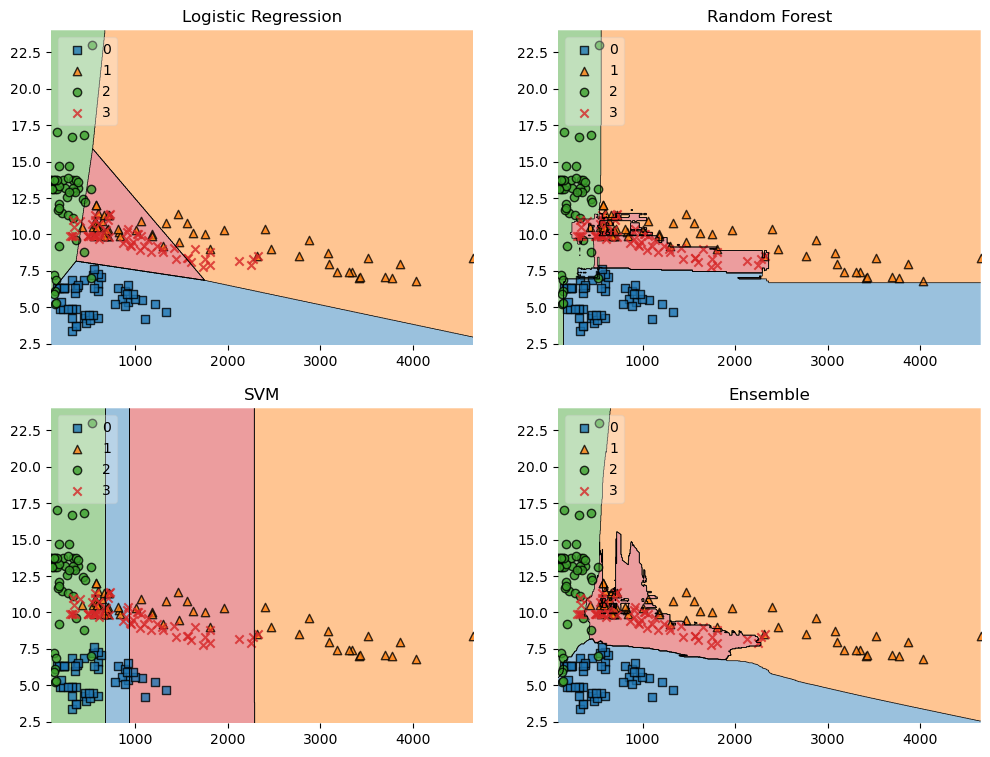

In [490]:
# Loading some example data
FEATURES_VIZUALIZE = ['Travellers (x 1,000)', 'Avg Length of Stay (x Nights)']
X_viz, y_viz, _, _ = get_X_y(FEATURES_VIZUALIZE)

plot_decision_regions_multi_model(X_viz.to_numpy(), y_viz)



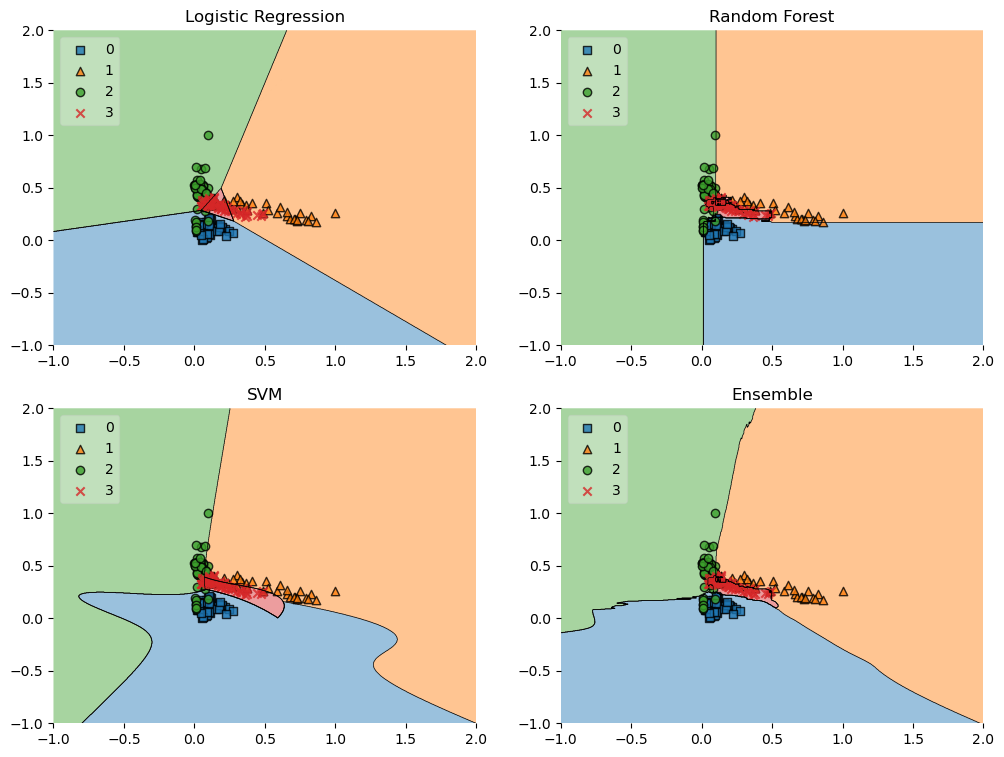

In [491]:
# Plot decision boundries on scaled features
scaler = MinMaxScaler()
plot_decision_regions_multi_model(scaler.fit_transform(X_viz), y_viz)

## Random Forest
Comparison of Machine learning models indicated that the Random Forest and ensemble models categorise the data better than the other models. The Random Forest model is the best model for this dataset.

RandomForestClassifier()

Accuracy: 0.9433962264150944
Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.91      0.91      0.91        11
           2       0.95      1.00      0.97        18
           3       0.88      0.78      0.82         9

    accuracy                           0.94        53
   macro avg       0.93      0.92      0.93        53
weighted avg       0.94      0.94      0.94        53



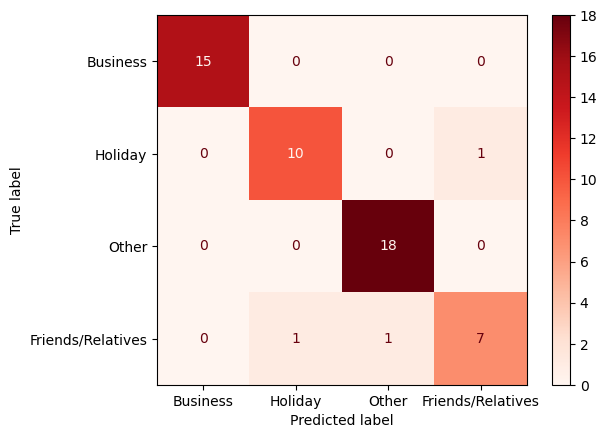

In [469]:
#Create a Gaussian Classifier
rf_clf=RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train,y_train)

predict_and_create_CM(rf_clf, X_test, y_test)

## Assess the importance of different features used for Random Forest Classification

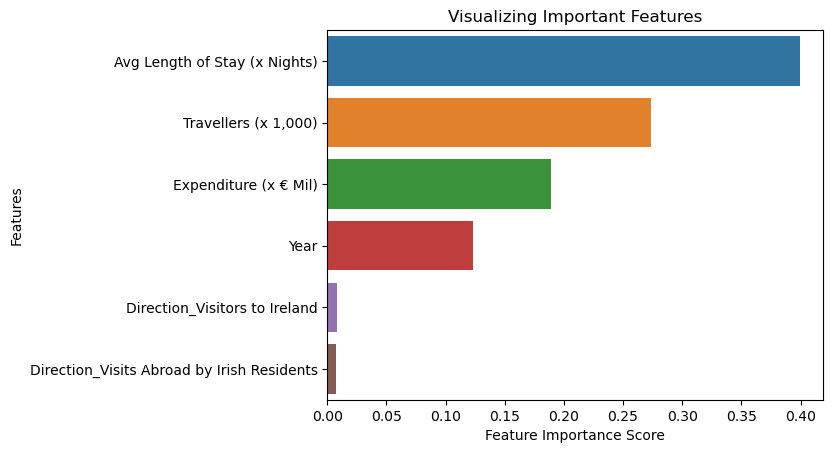

In [470]:

feature_imp = pd.Series(rf_clf.feature_importances_,index=FEATURES).sort_values(ascending=False)
feature_imp

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index);
# Add labels to your graph
plt.xlabel('Feature Importance Score');
plt.ylabel('Features');
plt.title("Visualizing Important Features");
plt.show();

### Random Forest, Test categorisation of sample data to test algorithm

In [471]:
pred = rf_clf.predict([[0.5, 0.17911101, 0.05344906, 0.32142857, 1., 0.]]) #Values corresponding to the 4th reason for travel - Visit to friends/relatives
pred

array([3])

!!! Random Forest gives better prediction accuracy than SVM - **94.34%**

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [100, 250, 500],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=1)

Best parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 250, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.9622641509433962
Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.91      0.91      0.91        11
           2       1.00      1.00      1.00        18
           3       0.89      0.89      0.89         9

    accuracy                           0.96        53
   macro avg       0.95      0.95      0.95        53
weighted avg       0.96      0.96      0.96        53



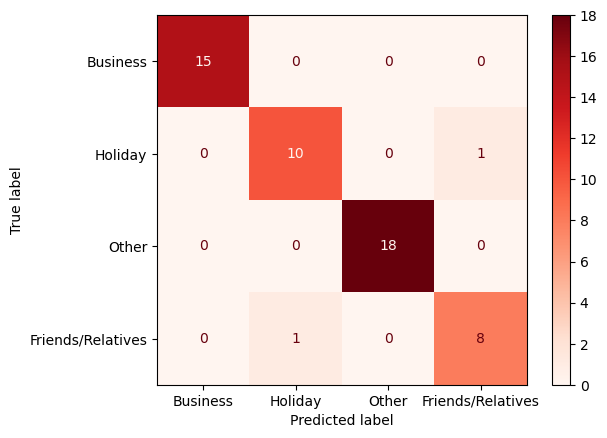

In [472]:
Random_forest_param_grid = {
    'n_estimators':[100,200],
    'max_features':['sqrt', 'log2'], 
    'max_depth':[100,250,500], 
    'min_samples_split':[2,5], 
    'min_samples_leaf':[1,2], 
    'bootstrap':[True,False],
    'criterion':['gini','entropy']}

rf_grid = GridSearchCV(RandomForestClassifier(), Random_forest_param_grid, verbose = 1)
rf_grid.fit(X_train,y_train)
predict_and_create_CM(rf_grid, X_test, y_test)

###### Using GridSearch for Random Forest_Took 55 mins to run_Identified optimal parameters as {'bootstrap': True, 'criterion': 'gini', 'max_depth': 250, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
                Precision   Recall     f1-score   support
           0       1.00      1.00      1.00        15
           1       0.91      0.91      0.91        11
           2       1.00      1.00      1.00        18
           3       0.89      0.89      0.89         9

    accuracy                           0.96        53
   macro avg       0.95      0.95      0.95        53
weighted avg       0.96      0.96      0.96        53



## KNN non-parametric algorithm
Advantages: No assumptions, simple, easily utilised for classification

Disadvantages: Sensitive to irrelevant features, sensitive to scale of data

Aim: Identify optimal # of neighbours for K Nearest Neighbour Model

Test Accuracy(1-10 neighbours): [0.86792453 0.9245283  0.86792453 0.86792453 0.83018868 0.86792453
 0.86792453 0.83018868 0.77358491 0.75471698]
Training Accuracy(1-10 neighbours): [1.         0.96682464 0.96208531 0.93364929 0.92890995 0.92890995
 0.90521327 0.90047393 0.8957346  0.88151659]


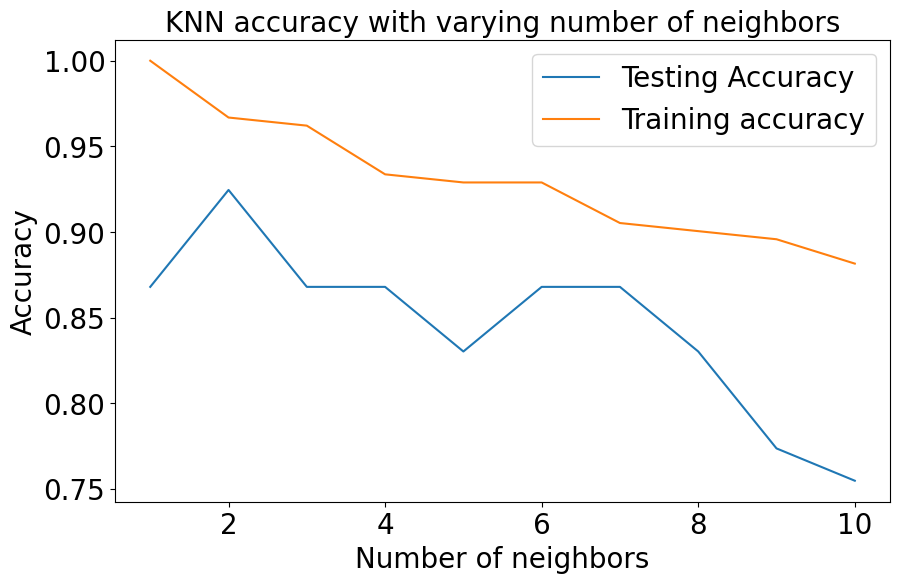

In [473]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = np.arange(1, 11)                  # Declare an array of values from 1 to 10 -> 1, 2, 3..., 10
train_accuracy = np.zeros(len(neighbors))    # Declare and initialise the matrix -> [0, 0, 0, ..., 0]
test_accuracy = np.zeros(len(neighbors))     # Declare and initialise the matrix -> [0, 0, 0, ..., 0]

for i,k in enumerate(neighbors):                          # for loop that checks the model for neighbor values 1, 2, 3, ..., 9
    knn = KNeighborsClassifier(n_neighbors = k)           # Initialise an object knn using KNeighborsClassifier method

    #Fit the model
    _ = knn.fit(X_train, y_train);                      # Call fit method to implement the ML KNeighborsClassifier model

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)   # Save the score value in the train_accuracy array

    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)      # Save the score value in the train_accuracy array

    # Delcare the size of the array
plt.figure(figsize = (10, 6))
plt.title('KNN accuracy with varying number of neighbors', fontsize = 20)
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training accuracy')
plt.legend(prop = {'size': 20})
plt.xlabel('Number of neighbors', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
print('Test Accuracy(1-10 neighbours):', test_accuracy)
print('Training Accuracy(1-10 neighbours):',train_accuracy)
plt.show();

*** For-loop identified the optimal # of neighbours in the range 1-10 to be 2, giving the best combined precision and recall with default distance metric Euclidean . This was however only run on one shuffle/split of the training/test data which can lead to over-fitting. Therefore, I wanted to use GridSearchCV to cross validate the selection of # of neighbours and distance metric. 

## GridSearchCV on KNN to select best hyperparameters on cross validated data

Tested parameters: {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'metric': ['euclidean', 'manhattan', 'minkowski']}


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='accuracy')

Best parameters: {'metric': 'manhattan', 'n_neighbors': 1}
Accuracy: 0.9056603773584906
Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.82      0.82      0.82        11
           2       0.95      1.00      0.97        18
           3       0.78      0.78      0.78         9

    accuracy                           0.91        53
   macro avg       0.89      0.88      0.88        53
weighted avg       0.91      0.91      0.91        53



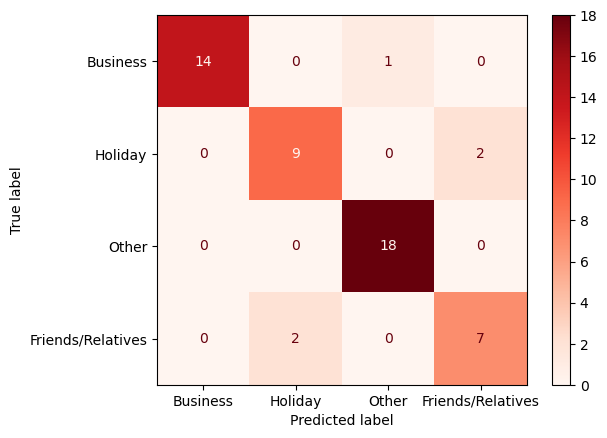

In [474]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

k_range = list(range(1, 31)) # Declare an array of values from 1 to 30 inclusive
param_grid = {'n_neighbors': k_range, 'metric': ['euclidean', 'manhattan', 'minkowski']} # Declaring dictionary of test parameters 
print('Tested parameters:', param_grid) 

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False) # Declaring GridSearchCV object
grid.fit(X_train, y_train)

predict_and_create_CM(grid, X_test, y_test)

GridSearchCV identified the optimal # of neighbours in the range 1-30 to be 1 and the distance metric 'manhattan' for precision of 91% on data. This was run on 5 shuffle/splits of the training/test data. Therefore, I want to repeat the KNN model with the identified parameters. 

### Rerun KNN with optimal neighbours, determined from KNN parameter selection

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

Train accuracy 1.0
Test accuracy 0.9056603773584906
Accuracy: 0.9056603773584906
Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.82      0.82      0.82        11
           2       0.95      1.00      0.97        18
           3       0.78      0.78      0.78         9

    accuracy                           0.91        53
   macro avg       0.89      0.88      0.88        53
weighted avg       0.91      0.91      0.91        53



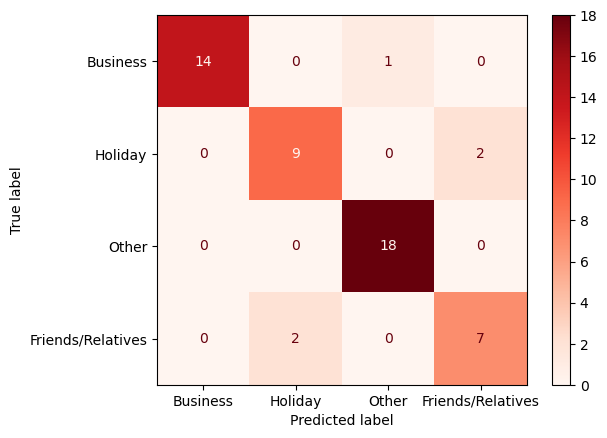

In [475]:
# Declare and initialise an object 'KNeighborsClassifier' with 2 neighbors
knn = KNeighborsClassifier(n_neighbors = 1, metric = 'manhattan') # Using distance as the metric

# Fit the model
knn.fit(X_train, y_train)

train_accuracy = knn.score(X_train, y_train) # Compute accuracy on the training set
test_accuracy = knn.score(X_test, y_test) # Compute accuracy on the test set
# Display the test accuracy
print('Train accuracy', train_accuracy)
print('Test accuracy', test_accuracy)

predict_and_create_CM(knn, X_test, y_test)